In [ ]:
#в этой версии задачи вместо one-hot encoder я использовала count-vectorizer на категориальных признаках типа cuisines, dish-liked, type, rest-type, city
#качество вышло немного лучше

In [1]:
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
import seaborn as sns
import math, random
from collections import defaultdict, Counter
from scipy import spatial
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import scipy

import warnings
warnings.filterwarnings("ignore")


In [138]:
data=pd.read_csv("../data/tripadvisor/tripadvisor.csv")

# Preprocessing of data

In [3]:
data.shape

(51717, 17)

In [4]:
data.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


In [139]:
data.rename(columns={'approx_cost(for two people)':'cost','listed_in(type)':'type','listed_in(city)':'city'}, inplace=True)

In [6]:
data.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,cost,reviews_list,menu_item,type,city
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


In [7]:
# оценим выбросы
data.isna().sum()

url                 0
address             0
name                0
online_order        0
book_table          0
rate             7775
votes               0
phone            1208
location           21
rest_type         227
dish_liked      28078
cuisines           45
cost              346
reviews_list        0
menu_item           0
type                0
city                0
dtype: int64

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   url           51717 non-null  object
 1   address       51717 non-null  object
 2   name          51717 non-null  object
 3   online_order  51717 non-null  object
 4   book_table    51717 non-null  object
 5   rate          43942 non-null  object
 6   votes         51717 non-null  int64 
 7   phone         50509 non-null  object
 8   location      51696 non-null  object
 9   rest_type     51490 non-null  object
 10  dish_liked    23639 non-null  object
 11  cuisines      51672 non-null  object
 12  cost          51371 non-null  object
 13  reviews_list  51717 non-null  object
 14  menu_item     51717 non-null  object
 15  type          51717 non-null  object
 16  city          51717 non-null  object
dtypes: int64(1), object(16)
memory usage: 6.7+ MB


In [9]:
data.rate.unique()

array(['4.1/5', '3.8/5', '3.7/5', '3.6/5', '4.6/5', '4.0/5', '4.2/5',
       '3.9/5', '3.1/5', '3.0/5', '3.2/5', '3.3/5', '2.8/5', '4.4/5',
       '4.3/5', 'NEW', '2.9/5', '3.5/5', nan, '2.6/5', '3.8 /5', '3.4/5',
       '4.5/5', '2.5/5', '2.7/5', '4.7/5', '2.4/5', '2.2/5', '2.3/5',
       '3.4 /5', '-', '3.6 /5', '4.8/5', '3.9 /5', '4.2 /5', '4.0 /5',
       '4.1 /5', '3.7 /5', '3.1 /5', '2.9 /5', '3.3 /5', '2.8 /5',
       '3.5 /5', '2.7 /5', '2.5 /5', '3.2 /5', '2.6 /5', '4.5 /5',
       '4.3 /5', '4.4 /5', '4.9/5', '2.1/5', '2.0/5', '1.8/5', '4.6 /5',
       '4.9 /5', '3.0 /5', '4.8 /5', '2.3 /5', '4.7 /5', '2.4 /5',
       '2.1 /5', '2.2 /5', '2.0 /5', '1.8 /5'], dtype=object)

In [10]:
data.rate.value_counts()

NEW       2208
3.9/5     2098
3.8/5     2022
3.7/5     2011
3.9 /5    1874
          ... 
2.2 /5       7
2.0 /5       7
2.0/5        4
1.8 /5       3
1.8/5        2
Name: rate, Length: 64, dtype: int64

In [11]:
data[data.rate.isna()]

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,cost,reviews_list,menu_item,type,city
84,https://www.zomato.com/bangalore/chill-out-ban...,"161/C, 6th Main, 80 Feet Road, Bhuvaneshwari N...",Chill Out,No,No,NaN,0,+91 9341215167,Banashankari,Quick Bites,NaN,"South Indian, Chinese",100,"[('Rated 4.0', 'RATED\n Good Location. Small ...",[],Delivery,Banashankari
90,https://www.zomato.com/bangalore/me-and-my-cak...,"BDA Shopping Complex, 24th Cross Road, Siddann...",Me And My Cake,No,No,NaN,0,+91 9036070410,Banashankari,Delivery,NaN,"Bakery, Desserts",500,"[('Rated 1.0', 'RATED\n Do not order anything...",[],Delivery,Banashankari
91,https://www.zomato.com/bangalore/sunsadm-banas...,"Shop 18 , 3rd cross road,Markandeya Layout, Ba...",Sunsadm,No,No,NaN,0,+91 7829290358,Banashankari,"Takeaway, Delivery",NaN,South Indian,400,[],[],Delivery,Banashankari
92,https://www.zomato.com/bangalore/annapooranesh...,"625, 5th Cross Road, Hanumanthnagar, Banashank...",Annapooraneshwari Mess,No,No,NaN,0,+91 9742009518,Banashankari,Mess,NaN,South Indian,200,[],[],Delivery,Banashankari
107,https://www.zomato.com/bangalore/coffee-shopee...,"1722, 13th Main Road 31st Cross BSK, 2nd Stage...",Coffee Shopee,No,No,NaN,0,+91 9591504624,Banashankari,"Takeaway, Delivery",NaN,Beverages,250,[],[],Delivery,Banashankari
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51644,https://www.zomato.com/bangalore/punjabi-thadk...,"7/3, ASK Tower, Kundanahalli Gate, Next to Bat...",Punjabi Thadka,No,No,NaN,0,+91 7338330336\n+91 9591568221,Brookefield,Quick Bites,NaN,North Indian,400,[],[],Dine-out,Whitefield
51675,https://www.zomato.com/bangalore/topsy-turvey-...,"2E2, 4th Cross Road, Devasandra Industrial Est...",Topsy Turvey,No,No,NaN,0,+91 9148155994,Whitefield,Bar,NaN,Finger Food,900,"[('Rated 4.0', ""RATED\n A divine joint for Fl...",[],Drinks & nightlife,Whitefield
51710,https://www.zomato.com/bangalore/topsy-turvey-...,"2E2, 4th Cross Road, Devasandra Industrial Est...",Topsy Turvey,No,No,NaN,0,+91 9148155994,Whitefield,Bar,NaN,Finger Food,900,"[('Rated 4.0', ""RATED\n A divine joint for Fl...",[],Pubs and bars,Whitefield
51713,https://www.zomato.com/bangalore/vinod-bar-and...,"Number 10, Garudachar Palya, Mahadevapura, Whi...",Vinod Bar And Restaurant,No,No,NaN,0,+91 8197675843,Whitefield,Bar,NaN,Finger Food,600,[],[],Pubs and bars,Whitefield


In [12]:
data[data.rate=='-']

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,cost,reviews_list,menu_item,type,city
3068,https://www.zomato.com/bangalore/house-of-tast...,"#235/1 12th Cross, Wilson Garden, Bangalore",House of Tasty Food,No,No,-,0,+91 9538004054,Wilson Garden,Quick Bites,NaN,North Indian,400,[],[],Delivery,Basavanagudi
3069,https://www.zomato.com/bangalore/super-chefs-b...,"8/3, Opposite Suryadhoya Convention hall, Bann...",Super Chef's (New Royal treat),No,No,-,0,NaN,Bannerghatta Road,Quick Bites,NaN,"North Indian, Chinese, South Indian",NaN,"[('Rated 1.0', 'RATED\n Many items were missi...",[],Delivery,Basavanagudi
3373,https://www.zomato.com/bangalore/right-pizza-b...,"Shop 9, East Anjanaiya Temple Street, Gandhi B...",Right Pizza,Yes,No,-,0,+91 9980473473\n+91 9845338098,Basavanagudi,Quick Bites,NaN,Pizza,300,[],[],Dine-out,Basavanagudi
3378,https://www.zomato.com/bangalore/mezban-family...,"Lalbagh Fort Road, basavanagudi, Banglore.",Mezban Family Restaurant,Yes,No,-,0,+91 9344609944\n+91 8072284844,Basavanagudi,Quick Bites,NaN,"Chinese, North Indian",300,"[('Rated 5.0', 'RATED\n Food was delicious es...",[],Dine-out,Basavanagudi
3387,https://www.zomato.com/bangalore/mota-bawarchi...,"19/A H. Siddhaiah Road, Sudhama Nagar, Opposit...",Mota Bawarchi,No,No,-,0,+91 9380109284,Basavanagudi,Quick Bites,NaN,"North Indian, Biryani, Fast Food",300,[],[],Dine-out,Basavanagudi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33454,https://www.zomato.com/bangalore/deepam-tiffin...,"4/1, 2nd Cross Road, 1st Stage, BTM Layout, Be...",Deepam Tiffins,No,No,-,0,+91 7003050054\n+91 9748122867,BTM,Quick Bites,NaN,"South Indian, North Indian, Chinese",300,"[('Rated 5.0', 'RATED\n \nGood'), ('Rated 5.0'...",[],Delivery,Koramangala 6th Block
33463,https://www.zomato.com/bangalore/hotel-orchid-...,"33, 1st Main, Bharathi Layout, SG Palya",Hotel Orchid,No,No,-,0,+91 9972304268,BTM,Casual Dining,NaN,"North Indian, South Indian, Chinese, Kerala",500,"[('Rated 3.0', ""RATED\n Good place with nice ...",[],Delivery,Koramangala 6th Block
45646,https://www.zomato.com/bangalore/sri-udupi-air...,"35, NAL Wind Tunnel Road, Opposite Top N Town,...",Sri Udupi,Yes,No,-,0,+91 8105663135\n+91 9845888813,Old Airport Road,Quick Bites,NaN,"South Indian, North Indian, Chinese, Beverages",400,"[('Rated 4.0', 'RATED\n A major revamp to the...",[],Dine-out,Old Airport Road
45647,https://www.zomato.com/bangalore/frozen-bite-a...,"22, Opposite Manjunatha Apartment, 5th Cross, ...",Frozen Bite,Yes,No,-,0,+91 9591922994\n+91 8041600292,Old Airport Road,Beverage Shop,NaN,Beverages,250,[],[],Dine-out,Old Airport Road


In [13]:
data[data.rate=='NEW']

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,cost,reviews_list,menu_item,type,city
72,https://www.zomato.com/bangalore/spicy-tandoor...,"Opposite ICICi Bank, Hanuman Nagar, Banashanka...",Spicy Tandoor,No,No,NEW,0,+91 8050884222,Banashankari,Quick Bites,NaN,North Indian,150,"[('Rated 4.0', 'RATED\n cost for chicken roll...",[],Delivery,Banashankari
75,https://www.zomato.com/bangalore/om-sri-vinaya...,"39, S B M Colony, Near-Sita Circle, 1st Stage,...",Om Sri Vinayaka Chats,No,No,NEW,0,+91 8553206035,Banashankari,"Takeaway, Delivery",NaN,"Street Food, Fast Food",500,[],[],Delivery,Banashankari
110,https://www.zomato.com/bangalore/hari-super-sa...,"594, 24 The Cross BSK, Opposte Oriental Bank, ...",Hari Super Sandwich,No,No,NEW,0,+91 9886722163,Banashankari,"Takeaway, Delivery",NaN,"Sandwich, Pizza, Beverages",200,"[('Rated 1.0', 'RATED\n I have been here many...",[],Delivery,Banashankari
130,https://www.zomato.com/bangalore/roll-magic-fa...,"28, 4th Cross Road, Dwaraka Nagar, Banashankar...",Roll Magic Fast Food,No,No,NEW,0,+91 9731409204,Banashankari,"Takeaway, Delivery",NaN,"Biryani, Rolls, Chinese",200,[],[],Delivery,Banashankari
131,https://www.zomato.com/bangalore/foodlieious-m...,"3/16, 22 Main Road, Magenta Block, PES College...",Foodlieious Multi Cuisine,No,No,NEW,0,+91 9168753522\r\n+91 8217877100,Banashankari,Quick Bites,NaN,North Indian,100,[],[],Delivery,Banashankari
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51585,https://www.zomato.com/bangalore/wow-tiffin-fo...,"Near Rama Temple, Immadihalli Road, Whitefield...",Wow Tiffin Food,No,No,NEW,0,+91 9535041209,Whitefield,Quick Bites,NaN,North Indian,200,[],[],Dine-out,Whitefield
51586,https://www.zomato.com/bangalore/quick-bites-w...,"119/5, Pattandur Agrahara, Near Brigade Tech p...",Quick Bites,Yes,No,NEW,0,+91 9742377087\n+91 7899303299,Whitefield,Quick Bites,NaN,Chinese,200,"[('Rated 5.0', 'RATED\n This is an awesome pl...","['Veg Chowmein + Manchurian', 'Paratha + Chick...",Dine-out,Whitefield
51603,https://www.zomato.com/bangalore/shiv-sagar-1-...,"Shop No 10, Food Court, 2nd Floor, Phoenix Mar...",Shiv sagar,Yes,No,NEW,0,+91 9513300048\n+91 8067266097,Whitefield,"Quick Bites, Food Court",NaN,"South Indian, Chinese, North Indian",250,"[('Rated 3.0', 'RATED\n A highly expensive pl...","['Malai Paneer Tikka', 'Paneer Kofta', 'Mushro...",Dine-out,Whitefield
51604,https://www.zomato.com/bangalore/nawab-di-biry...,"17, Thubarahalli Village, Hobli, Varthur Main ...",Nawab Di Biryani,No,No,NEW,0,+91 7899298400\n+91 9818654628,Whitefield,"Takeaway, Delivery",NaN,"Biryani, Mughlai",400,"[('Rated 3.0', 'RATED\n Biriyani had ordered ...",[],Dine-out,Whitefield


In [14]:
#преобразуем столбец rate в вещественное число
def rate_preprocessing(x):
    if x not in ["NEW", "-"] and type(x) != float:
        return round(float(x.split('/')[0].strip()),1)



In [140]:
#заменим "NEW" и "-" рейтинги на NaN
data['rate']=data['rate'].replace("NEW", np.nan)
data['rate']=data['rate'].replace("-", np.nan)

In [141]:
#делаем рейтинги вещественными
data['rate']=data['rate'].map(rate_preprocessing)

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   url           51717 non-null  object 
 1   address       51717 non-null  object 
 2   name          51717 non-null  object 
 3   online_order  51717 non-null  object 
 4   book_table    51717 non-null  object 
 5   rate          41665 non-null  float64
 6   votes         51717 non-null  int64  
 7   phone         50509 non-null  object 
 8   location      51696 non-null  object 
 9   rest_type     51490 non-null  object 
 10  dish_liked    23639 non-null  object 
 11  cuisines      51672 non-null  object 
 12  cost          51371 non-null  object 
 13  reviews_list  51717 non-null  object 
 14  menu_item     51717 non-null  object 
 15  type          51717 non-null  object 
 16  city          51717 non-null  object 
dtypes: float64(1), int64(1), object(15)
memory usage: 6.7+ MB


In [18]:
#все url - это сайт ресторана
data.url.unique()

array(['https://www.zomato.com/bangalore/jalsa-banashankari?context=eyJzZSI6eyJlIjpbNTg2OTQsIjE4Mzc1NDc0IiwiNTkwOTAiLCIxODM4Mjk0NCIsIjE4MjI0Njc2IiwiNTkyODkiLCIxODM3MzM4NiJdLCJ0IjoiUmVzdGF1cmFudHMgaW4gQmFuYXNoYW5rYXJpIHNlcnZpbmcgQnVmZmV0In19',
       'https://www.zomato.com/bangalore/spice-elephant-banashankari?context=eyJzZSI6eyJlIjpbIjU4Njk0IiwxODM3NTQ3NCwiNTkwOTAiLCIxODM4Mjk0NCIsIjE4MjI0Njc2IiwiNTkyODkiLCIxODM3MzM4NiJdLCJ0IjoiUmVzdGF1cmFudHMgaW4gQmFuYXNoYW5rYXJpIHNlcnZpbmcgQnVmZmV0In19',
       'https://www.zomato.com/SanchurroBangalore?context=eyJzZSI6eyJlIjpbIjU4Njk0IiwiMTgzNzU0NzQiLDU5MDkwLCIxODM4Mjk0NCIsIjE4MjI0Njc2IiwiNTkyODkiLCIxODM3MzM4NiJdLCJ0IjoiUmVzdGF1cmFudHMgaW4gQmFuYXNoYW5rYXJpIHNlcnZpbmcgQnVmZmV0In19',
       ...,
       'https://www.zomato.com/bangalore/plunge-sheraton-grand-bengaluru-whitefield-hotel-convention-centre-whitefield-bangalore?context=eyJzZSI6eyJlIjpbIjE4NjAyNDc4IiwiMTgyOTAwNTIiLCI1ODM1NCIsIjE4NzQxMTI5IiwxODY2MTA0MCwiMTg2NjEwODQiLCIxODY5MDgzNyJdLCJ0IjoiUHV

In [19]:
#имена ресторана
data.name

0                                                    Jalsa
1                                           Spice Elephant
2                                          San Churro Cafe
3                                    Addhuri Udupi Bhojana
4                                            Grand Village
                               ...                        
51712    Best Brews - Four Points by Sheraton Bengaluru...
51713                             Vinod Bar And Restaurant
51714    Plunge - Sheraton Grand Bengaluru Whitefield H...
51715    Chime - Sheraton Grand Bengaluru Whitefield Ho...
51716                         The Nest - The Den Bengaluru
Name: name, Length: 51717, dtype: object

In [20]:
# не уникальные
data.name.nunique()

8792

In [21]:
data.url.nunique()

51717

In [22]:
#все отзывы на ресторан c рейтингами
data.reviews_list[0]

'[(\'Rated 4.0\', \'RATED\\n  A beautiful place to dine in.The interiors take you back to the Mughal era. The lightings are just perfect.We went there on the occasion of Christmas and so they had only limited items available. But the taste and service was not compromised at all.The only complaint is that the breads could have been better.Would surely like to come here again.\'), (\'Rated 4.0\', \'RATED\\n  I was here for dinner with my family on a weekday. The restaurant was completely empty. Ambience is good with some good old hindi music. Seating arrangement are good too. We ordered masala papad, panner and baby corn starters, lemon and corrionder soup, butter roti, olive and chilli paratha. Food was fresh and good, service is good too. Good for family hangout.\\nCheers\'), (\'Rated 2.0\', \'RATED\\n  Its a restaurant near to Banashankari BDA. Me along with few of my office friends visited to have buffet but unfortunately they only provide veg buffet. On inquiring they said this plac

In [23]:
#посчитаем средний рейтинг по отзывам
def get_avg_rating(x):
    regex = re.compile("[0-9]{1}\.[0-9]{1}")
    rating_list=regex.findall(x)
    rating_list=list(map(float, rating_list))
    return round(np.mean(rating_list),1)

In [142]:
#создадим признак - средняя оценка из отзывов
data['avg_rate']=data.reviews_list.map(get_avg_rating)

In [143]:
data[['rate','avg_rate']]

,rate,avg_rate
0,4.1,4.1
1,4.1,3.5
2,3.8,3.4
3,3.7,3.6
4,3.8,3.8
...,...,...
51712,3.6,4.1
51713,NaN,NaN
51714,NaN,NaN
51715,4.3,4.0


In [144]:
data.drop(columns=['reviews_list'], inplace=True)

In [27]:
data.loc[data.rate.isna() & data.avg_rate.isna()]

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,cost,menu_item,type,city,avg_rate
75,https://www.zomato.com/bangalore/om-sri-vinaya...,"39, S B M Colony, Near-Sita Circle, 1st Stage,...",Om Sri Vinayaka Chats,No,No,NaN,0,+91 8553206035,Banashankari,"Takeaway, Delivery",NaN,"Street Food, Fast Food",500,[],Delivery,Banashankari,NaN
91,https://www.zomato.com/bangalore/sunsadm-banas...,"Shop 18 , 3rd cross road,Markandeya Layout, Ba...",Sunsadm,No,No,NaN,0,+91 7829290358,Banashankari,"Takeaway, Delivery",NaN,South Indian,400,[],Delivery,Banashankari,NaN
92,https://www.zomato.com/bangalore/annapooranesh...,"625, 5th Cross Road, Hanumanthnagar, Banashank...",Annapooraneshwari Mess,No,No,NaN,0,+91 9742009518,Banashankari,Mess,NaN,South Indian,200,[],Delivery,Banashankari,NaN
107,https://www.zomato.com/bangalore/coffee-shopee...,"1722, 13th Main Road 31st Cross BSK, 2nd Stage...",Coffee Shopee,No,No,NaN,0,+91 9591504624,Banashankari,"Takeaway, Delivery",NaN,Beverages,250,[],Delivery,Banashankari,NaN
113,https://www.zomato.com/bangalore/dharwad-line-...,"Shop 25, 1st Cross, 50 Feet Main Road, Near BD...",Dharwad Line Bazaar Mishra Pedha,No,No,NaN,0,+91 9901539269,Banashankari,Dessert Parlor,NaN,Mithai,150,[],Delivery,Banashankari,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51642,https://www.zomato.com/bangalore/basaveshwara-...,"Nanjudeshwari complex, Oppsite Brookefield Mal...",Basaveshwara Khanavali,No,No,NaN,0,+91 9740912864\n+91 7353747430,Brookefield,Quick Bites,NaN,South Indian,200,[],Dine-out,Whitefield,NaN
51643,https://www.zomato.com/bangalore/new-ambur-bir...,"AECS Layout, ITPL Main Road, Brookefield, Bang...",New Ambur Biryani,No,No,NaN,0,+91 9443087893,Brookefield,Quick Bites,NaN,"Biryani, Kebab",300,[],Dine-out,Whitefield,NaN
51644,https://www.zomato.com/bangalore/punjabi-thadk...,"7/3, ASK Tower, Kundanahalli Gate, Next to Bat...",Punjabi Thadka,No,No,NaN,0,+91 7338330336\n+91 9591568221,Brookefield,Quick Bites,NaN,North Indian,400,[],Dine-out,Whitefield,NaN
51713,https://www.zomato.com/bangalore/vinod-bar-and...,"Number 10, Garudachar Palya, Mahadevapura, Whi...",Vinod Bar And Restaurant,No,No,NaN,0,+91 8197675843,Whitefield,Bar,NaN,Finger Food,600,[],Pubs and bars,Whitefield,NaN


In [145]:
#заменим NaN, NEW, - в рейтинг столбце на его средний рейтинг по другим отзывам
data.loc[data.rate.isna(),'rate']=data.loc[data.rate.isna(),'avg_rate']

In [146]:
#удаляем те строки, где средний рейтинг NaN и основной рейтинг NaN
data.drop(data.loc[data.rate.isna() & data.avg_rate.isna()].index, inplace=True)

In [30]:
data.rate.isna().sum()

0

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45243 entries, 0 to 51716
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   url           45243 non-null  object 
 1   address       45243 non-null  object 
 2   name          45243 non-null  object 
 3   online_order  45243 non-null  object 
 4   book_table    45243 non-null  object 
 5   rate          45243 non-null  float64
 6   votes         45243 non-null  int64  
 7   phone         44271 non-null  object 
 8   location      45243 non-null  object 
 9   rest_type     45083 non-null  object 
 10  dish_liked    23632 non-null  object 
 11  cuisines      45226 non-null  object 
 12  cost          44945 non-null  object 
 13  menu_item     45243 non-null  object 
 14  type          45243 non-null  object 
 15  city          45243 non-null  object 
 16  avg_rate      44122 non-null  float64
dtypes: float64(2), int64(1), object(14)
memory usage: 6.2+ MB


In [32]:
data.phone.nunique()

13094

In [147]:
#удаляем столбцы, не несущие важной информации: phone, address, url
data.drop(columns=['phone','address', 'url'], axis=1, inplace=True)

In [34]:
data.head()

,name,online_order,book_table,rate,votes,location,rest_type,dish_liked,cuisines,cost,menu_item,type,city,avg_rate
0,Jalsa,Yes,Yes,4.1,775,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,[],Buffet,Banashankari,4.1
1,Spice Elephant,Yes,No,4.1,787,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,[],Buffet,Banashankari,3.5
2,San Churro Cafe,Yes,No,3.8,918,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,[],Buffet,Banashankari,3.4
3,Addhuri Udupi Bhojana,No,No,3.7,88,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,[],Buffet,Banashankari,3.6
4,Grand Village,No,No,3.8,166,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,[],Buffet,Banashankari,3.8


In [35]:
data.menu_item.unique()

array(['[]',
       "['Chocolate Fantasy (Pack Of 5)', 'Pan Cake (Pack Of 6)', 'Gulab Jamun (Pack Of 10)', 'Gulkand Shot (Pack Of 5)', 'Chocolate Decadence (Pack of 2)', 'CheeseCake (Pack Of 2)', 'Red Velvet Slice Cake (Pack of 2)', 'Red Velvet Slice Cake & Cheese Cake (Pack of 2)', 'Red Velvet Slice Cake & Chocolate Decadence Cake (Pack of 2)', 'Hazelnut Brownie (Pack of 2)', 'Moments', 'Red Velvet Cake With Butter Cream Frosting (750 Gm)', 'Red Velvet Slice Cake (Pack of 2)', 'Red Velvet Slice Cake & Cheese Cake (Pack of 2)', 'Red Velvet Slice Cake & Chocolate Decadence Cake (Pack of 2)', 'Red Velvet Slice Cake (Pack of 1)', 'Valentine Red Velvet Jar', 'Valentine Chocolate Jar', 'Valentines Jar Combo', 'Pink Guava 500 ML', 'Oreo Vanilla 500 ML', 'Cookie Crumble 500 ML', 'Chocolate Fantasy', 'Gulkand-E-Bahar', 'Pan Cake', 'Hazelnut Brownie (Pack Of 1)', 'Gulab Jamun (Pack Of 2)', 'Plum Cake', 'Red Velvet Cake With Butter Cream Frosting (750 Gm)', 'Chocolate Mud Cake (700 Gms)', 'Chees

In [148]:
#удаляем колонку с меню, вместо нее оставим информацию dish_liked
data.drop(columns=['menu_item'], inplace=True)

In [37]:
data[['location','city']]

,location,city
0,Banashankari,Banashankari
1,Banashankari,Banashankari
2,Banashankari,Banashankari
3,Banashankari,Banashankari
4,Basavanagudi,Banashankari
...,...,...
51710,Whitefield,Whitefield
51711,Whitefield,Whitefield
51712,Whitefield,Whitefield
51715,"ITPL Main Road, Whitefield",Whitefield


In [38]:
data['location'].nunique()

92

In [39]:
data['location'].value_counts()

BTM                      4342
Koramangala 5th Block    2416
HSR                      2229
Indiranagar              1942
JP Nagar                 1905
                         ... 
West Bangalore              6
Yelahanka                   5
Rajarajeshwari Nagar        2
Nagarbhavi                  1
Peenya                      1
Name: location, Length: 92, dtype: int64

In [40]:
data['city'].nunique()

30

In [41]:
data['city'].value_counts()

BTM                      2867
Koramangala 7th Block    2572
Koramangala 5th Block    2478
Koramangala 4th Block    2467
Koramangala 6th Block    2317
Jayanagar                2093
JP Nagar                 1818
Indiranagar              1672
MG Road                  1638
Church Street            1633
Brigade Road             1583
Lavelle Road             1550
HSR                      1493
Residency Road           1448
Marathahalli             1433
Bannerghatta Road        1369
Whitefield               1360
Old Airport Road         1298
Brookefield              1280
Kammanahalli             1140
Basavanagudi             1136
Kalyan Nagar             1118
Sarjapur Road            1112
Bellandur                1063
Frazer Town              1044
Malleshwaram              990
Electronic City           947
Rajajinagar               939
Banashankari              777
New BEL Road              608
Name: city, dtype: int64

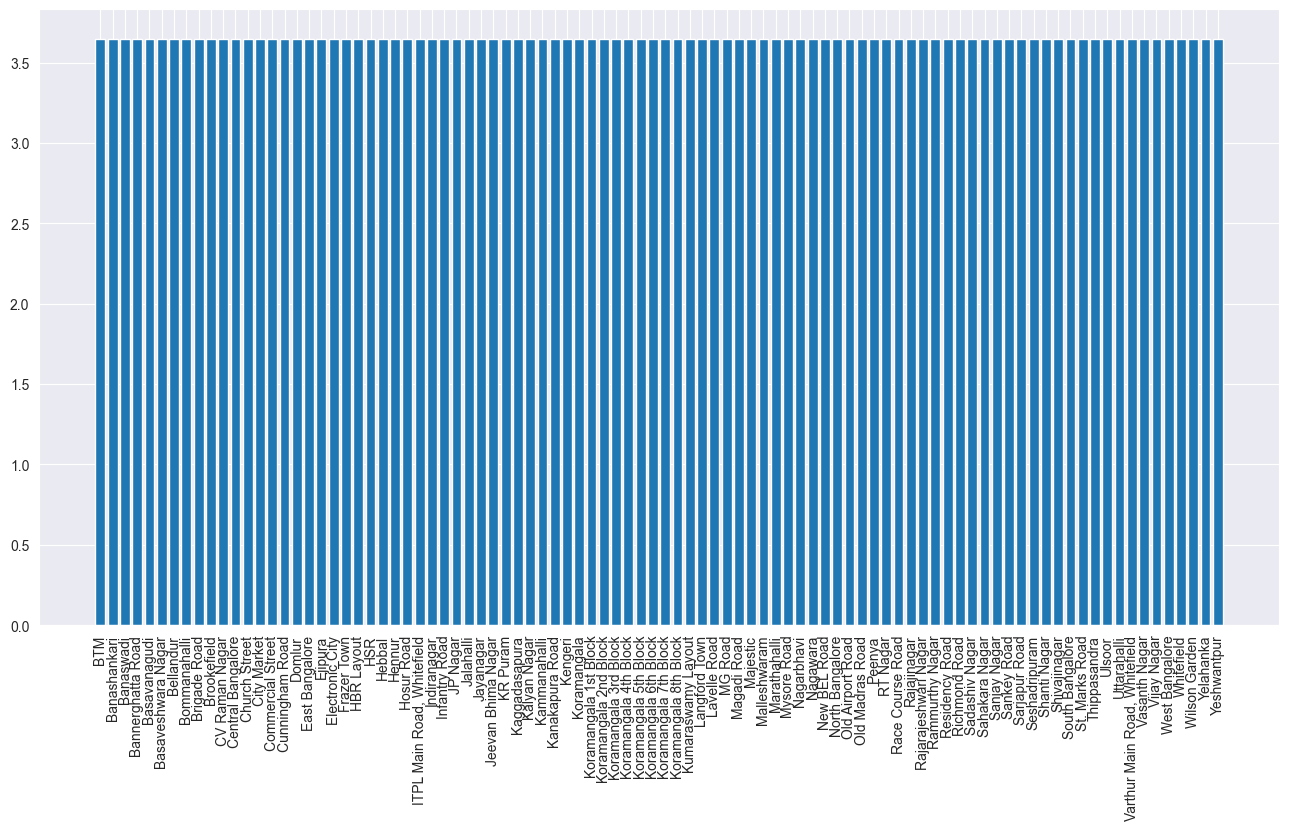

In [42]:
#как зависят рейтинги от location
data_by_location = data.groupby('location')['rate'].mean()
plt.figure(figsize=(16, 8))
plt.bar(x=data_by_location.index, height=data_by_location.mean())
plt.xticks(rotation=90)
plt.show()

In [149]:
#примерно одинаково, удаляем
data.drop(columns=['location'], inplace=True)

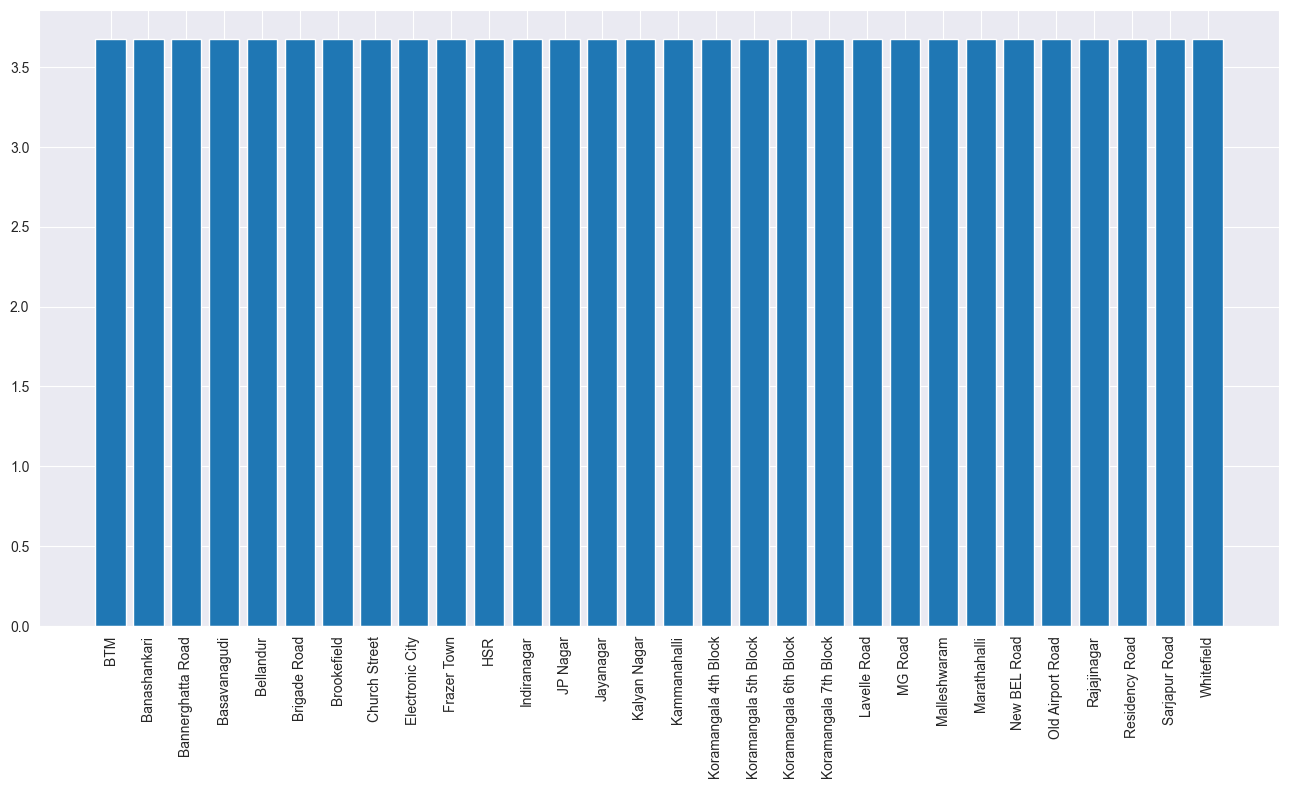

In [44]:
#посмотрим как зависят рейтинги от города
data_by_city=data.groupby('city')['rate'].mean()
plt.figure(figsize=(16,8))
plt.bar(x=data_by_city.index, height=data_by_city.mean())
plt.xticks(rotation=90)
plt.show()

In [45]:
#от города средний рейтинг не сильно зависит, посмотрим на тип заведения

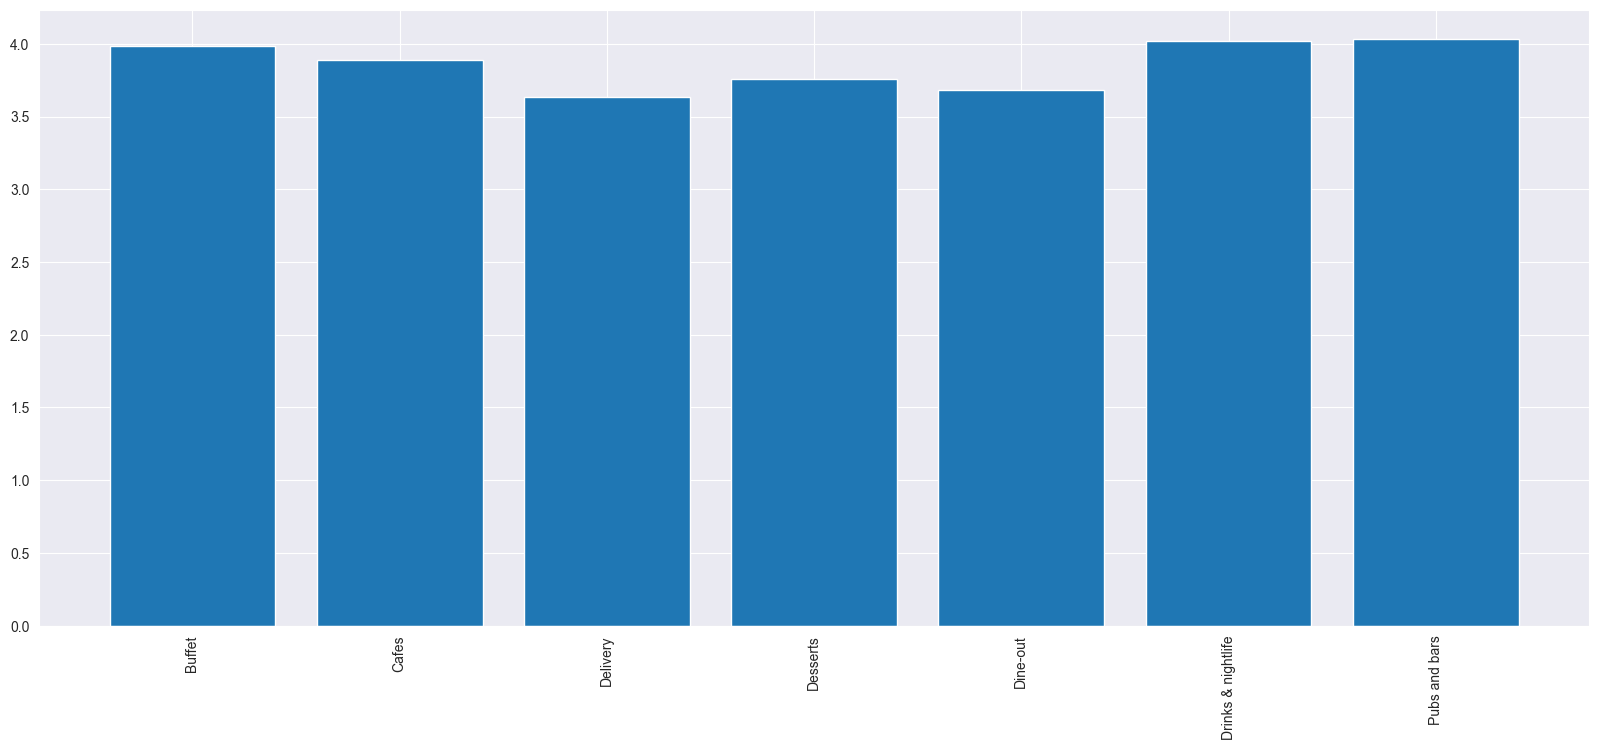

In [46]:
data_by_types=data.groupby('type')['rate'].mean()
plt.figure(figsize=(20,8))
plt.bar(x=data_by_types.index, height=data_by_types)
plt.xticks(rotation=90)
plt.show()

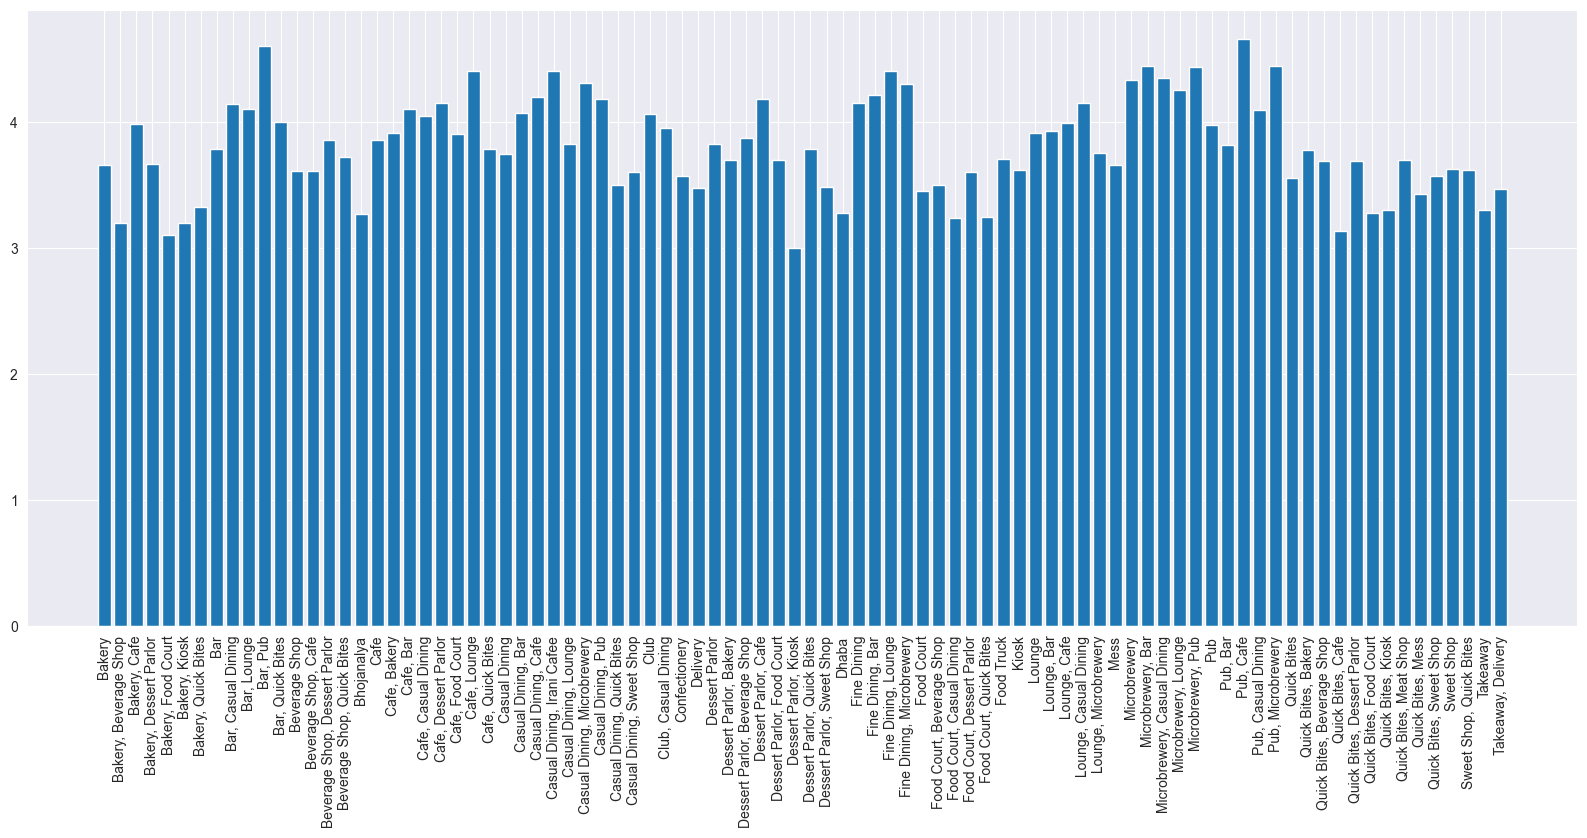

In [47]:
#зависимость от типа ресторана (ecть)
data_by_rest_types = data.groupby('rest_type')['rate'].mean()
plt.figure(figsize=(20, 8))
plt.bar(x=data_by_rest_types.index, height=data_by_rest_types)
plt.xticks(rotation=90)
plt.show()

In [48]:
data['cuisines'].value_counts()

North Indian                             2421
North Indian, Chinese                    2129
South Indian                             1395
Bakery, Desserts                          724
Biryani                                   693
                                         ... 
North Indian, Chinese, Arabian, Kebab       1
Chinese, Street Food, Ice Cream             1
Turkish, Fast Food, Biryani, Chinese        1
Mithai, Gujarati                            1
North Indian, Chinese, Arabian, Momos       1
Name: cuisines, Length: 2503, dtype: int64

In [49]:
# сформируем списки уникальных значений для cousines, dish_liked, res_type, city

In [50]:
def items_list(data):
    dishes=[]
    for i in range(len(data)):
        try:
           for word in data.iloc[i].split(","):
               dishes.append(word.lower().strip())
        except:
            continue
    return set(dishes)


In [51]:
dishes=items_list(data['dish_liked'])

In [52]:
dishes

{'belgian chocolate milkshake',
 'amritsari kulcha',
 'dumplings',
 'fish grill',
 'sangria',
 'dal panchmel',
 'choco mocha',
 'murgh lababdar',
 'lobster',
 'chole kulcha',
 'basket chat',
 'long island iced tea',
 'tamda rassa',
 'chicken wonton soup',
 'soba noodles',
 'gooey brownie',
 'open dosa',
 'chocolate decadence',
 'peri peri maggi',
 'meat eater pizza',
 'open masala dosa',
 'benne dosa',
 'bhetki paturi',
 'eggs benedict',
 'chocolate roll',
 'fajita',
 'aam panna',
 'banana waffles',
 'croissant',
 'cheese burst pizza',
 'calcutta paan',
 'sauteed vegetables',
 'veg cheese sandwich',
 'chana daal',
 'sunday breakfast',
 'banana cake',
 'squid rings',
 'coconut rice',
 'monster pizza',
 'paneer puff',
 'nutella cookie',
 'papdi chaat',
 'kashmiri pulao',
 'steak burger',
 'cuban mojito',
 'fried fish',
 'tandoori chaap',
 'lemon rice',
 'kung pao chicken',
 'baked chicken',
 'palak paneer paratha',
 'ice-cream shake',
 'cheesecake ice cream',
 'potato pops',
 'anjeer kul

In [53]:
len(dishes)

2792

In [54]:
data['cuisines'].value_counts()

North Indian                             2421
North Indian, Chinese                    2129
South Indian                             1395
Bakery, Desserts                          724
Biryani                                   693
                                         ... 
North Indian, Chinese, Arabian, Kebab       1
Chinese, Street Food, Ice Cream             1
Turkish, Fast Food, Biryani, Chinese        1
Mithai, Gujarati                            1
North Indian, Chinese, Arabian, Momos       1
Name: cuisines, Length: 2503, dtype: int64

In [55]:
cuisines=items_list(data['cuisines'])

In [56]:
cuisines

{'afghan',
 'afghani',
 'african',
 'american',
 'andhra',
 'arabian',
 'asian',
 'assamese',
 'australian',
 'awadhi',
 'bakery',
 'bar food',
 'bbq',
 'belgian',
 'bengali',
 'beverages',
 'bihari',
 'biryani',
 'bohri',
 'british',
 'bubble tea',
 'burger',
 'burmese',
 'cafe',
 'cantonese',
 'charcoal chicken',
 'chettinad',
 'chinese',
 'coffee',
 'continental',
 'desserts',
 'drinks only',
 'european',
 'fast food',
 'finger food',
 'french',
 'german',
 'goan',
 'greek',
 'grill',
 'gujarati',
 'healthy food',
 'hot dogs',
 'hyderabadi',
 'ice cream',
 'indian',
 'indonesian',
 'iranian',
 'italian',
 'japanese',
 'jewish',
 'juices',
 'kashmiri',
 'kebab',
 'kerala',
 'konkan',
 'korean',
 'lebanese',
 'lucknowi',
 'maharashtrian',
 'malaysian',
 'mangalorean',
 'mediterranean',
 'mexican',
 'middle eastern',
 'mithai',
 'modern indian',
 'momos',
 'mongolian',
 'mughlai',
 'naga',
 'nepalese',
 'north eastern',
 'north indian',
 'oriya',
 'paan',
 'pan asian',
 'parsi',
 'pizz

In [57]:
len(cuisines)

106

In [58]:
rest_types=items_list(data['rest_type'])

In [59]:
rest_types

{'bakery',
 'bar',
 'beverage shop',
 'bhojanalya',
 'cafe',
 'casual dining',
 'club',
 'confectionery',
 'delivery',
 'dessert parlor',
 'dhaba',
 'fine dining',
 'food court',
 'food truck',
 'irani cafee',
 'kiosk',
 'lounge',
 'meat shop',
 'mess',
 'microbrewery',
 'pub',
 'quick bites',
 'sweet shop',
 'takeaway'}

In [60]:
len(rest_types)

24

In [61]:
types=items_list(data['type'])

In [62]:
types

{'buffet',
 'cafes',
 'delivery',
 'desserts',
 'dine-out',
 'drinks & nightlife',
 'pubs and bars'}

In [63]:
cities=items_list(data['city'])

In [64]:
cities

{'banashankari',
 'bannerghatta road',
 'basavanagudi',
 'bellandur',
 'brigade road',
 'brookefield',
 'btm',
 'church street',
 'electronic city',
 'frazer town',
 'hsr',
 'indiranagar',
 'jayanagar',
 'jp nagar',
 'kalyan nagar',
 'kammanahalli',
 'koramangala 4th block',
 'koramangala 5th block',
 'koramangala 6th block',
 'koramangala 7th block',
 'lavelle road',
 'malleshwaram',
 'marathahalli',
 'mg road',
 'new bel road',
 'old airport road',
 'rajajinagar',
 'residency road',
 'sarjapur road',
 'whitefield'}

In [65]:
data.head()

,name,online_order,book_table,rate,votes,rest_type,dish_liked,cuisines,cost,type,city,avg_rate
0,Jalsa,Yes,Yes,4.1,775,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,Buffet,Banashankari,4.1
1,Spice Elephant,Yes,No,4.1,787,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,Buffet,Banashankari,3.5
2,San Churro Cafe,Yes,No,3.8,918,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,Buffet,Banashankari,3.4
3,Addhuri Udupi Bhojana,No,No,3.7,88,Quick Bites,Masala Dosa,"South Indian, North Indian",300,Buffet,Banashankari,3.6
4,Grand Village,No,No,3.8,166,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,Buffet,Banashankari,3.8


In [66]:
# Почистим столбец cost и сделаем средним для 1 человека

In [67]:
def clear_cost(x):
    if type(x) != float:
        x=x.replace(',',"")
    return float(x)/2

In [150]:
data['cost']=data['cost'].map(clear_cost)

In [151]:
data['cost'].astype(float)

0         400.0
1         400.0
2         400.0
3         150.0
4         300.0
          ...  
51710     450.0
51711     400.0
51712     750.0
51715    1250.0
51716     750.0
Name: cost, Length: 45243, dtype: float64

In [70]:
data.dtypes

name             object
online_order     object
book_table       object
rate            float64
votes             int64
rest_type        object
dish_liked       object
cuisines         object
cost            float64
type             object
city             object
avg_rate        float64
dtype: object

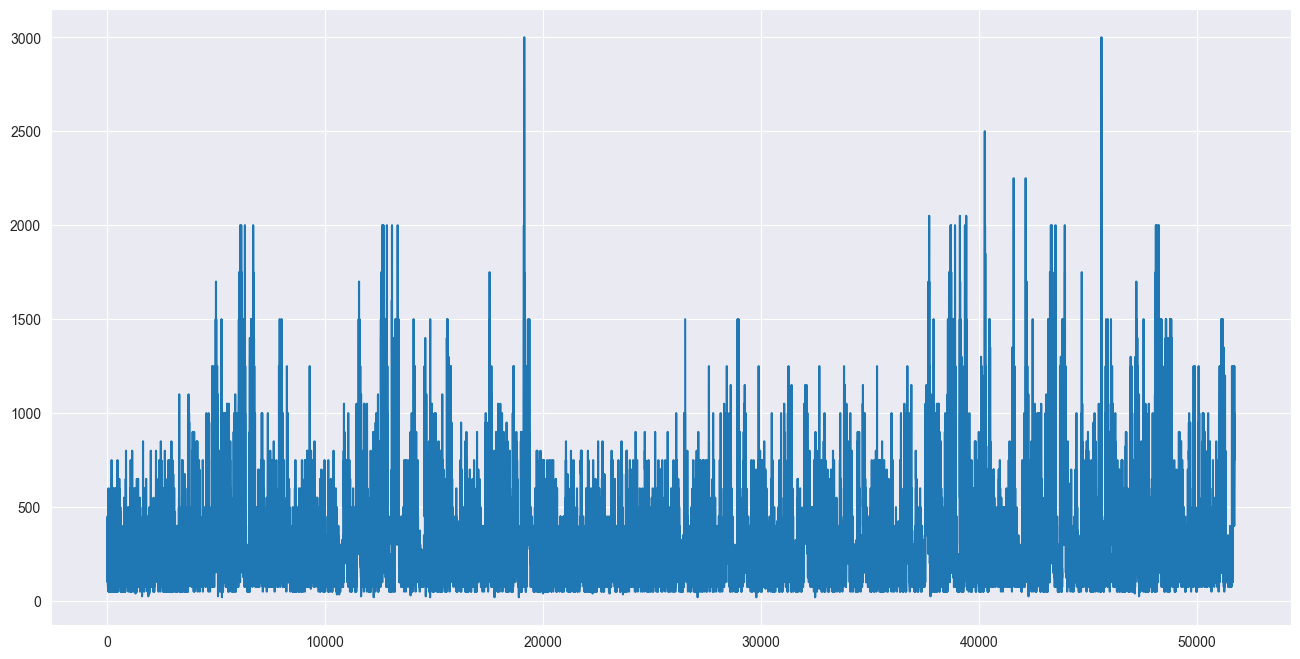

In [71]:
#есть выбросы по ценам
plt.figure(figsize=(16,8))
plt.plot(data['cost'])
plt.show()

In [72]:
data['cost'].describe()

count    44945.000000
mean       293.169830
std        227.592478
min         20.000000
25%        150.000000
50%        225.000000
75%        350.000000
max       3000.000000
Name: cost, dtype: float64

<AxesSubplot: >

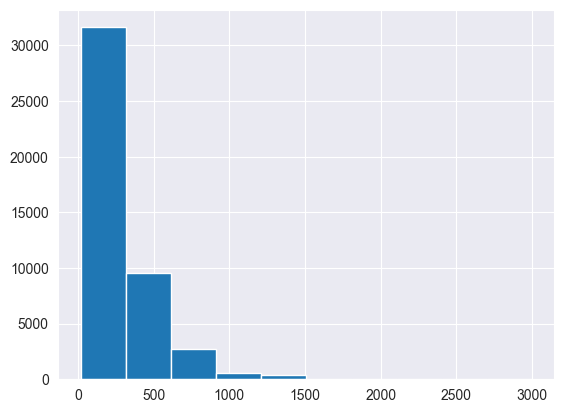

In [73]:
# данные не равномерно распределены по стоимости
data['cost'].hist()

In [74]:
data['votes'].describe()

count    45243.000000
mean       324.278717
std        851.740243
min          0.000000
25%         15.000000
50%         59.000000
75%        241.000000
max      16832.000000
Name: votes, dtype: float64

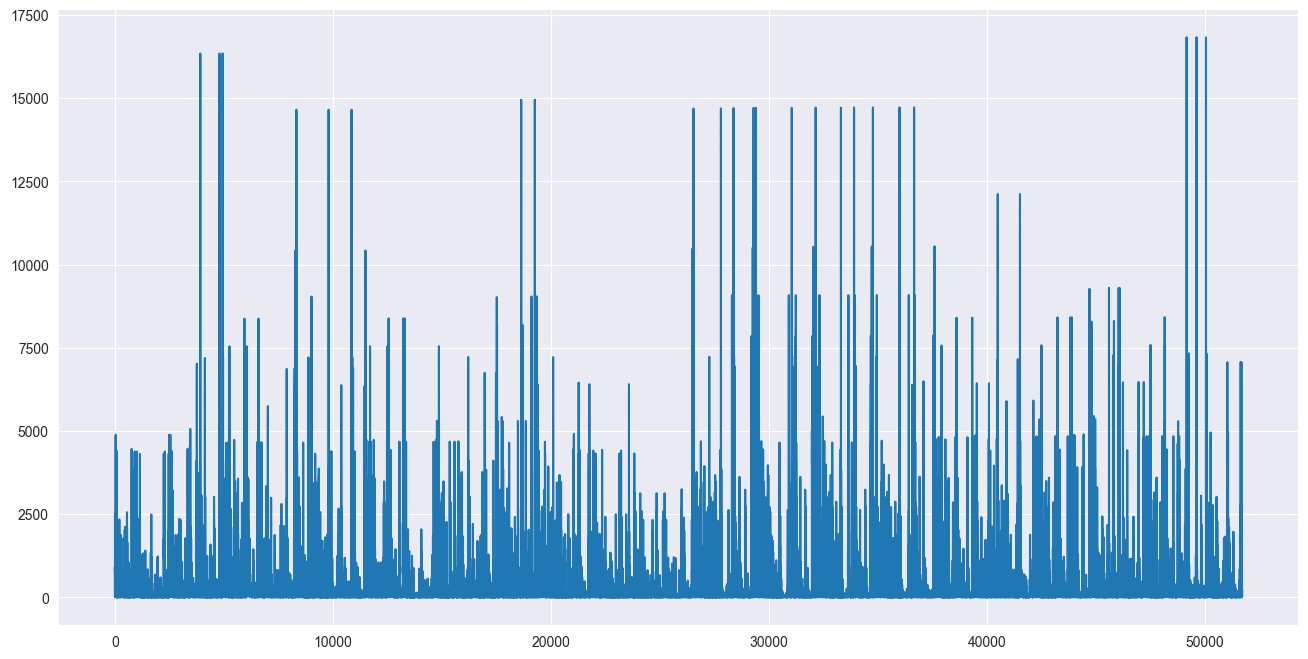

In [75]:
plt.figure(figsize=(16,8))
plt.plot(data['votes'])
plt.show()

<AxesSubplot: >

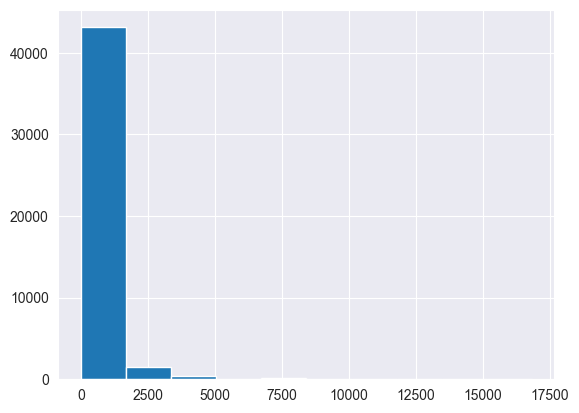

In [76]:
data['votes'].hist()

In [77]:
#связь votes, rate, avg_rate, cost

<AxesSubplot: >

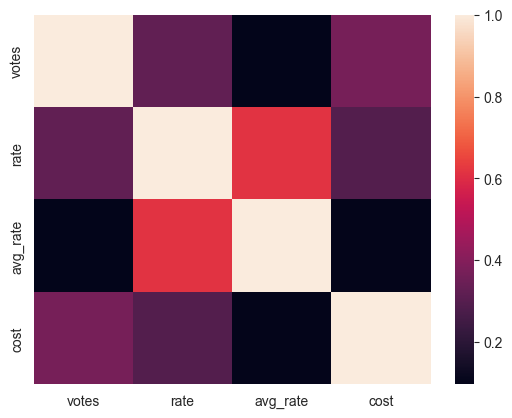

In [78]:
sns.heatmap(data[['votes','rate','avg_rate','cost']].corr())
#votes связаны с rate

# Избавляемся от NaN (где это возможно)

In [79]:
data.isna().sum()

name                0
online_order        0
book_table          0
rate                0
votes               0
rest_type         160
dish_liked      21611
cuisines           17
cost              298
type                0
city                0
avg_rate         1121
dtype: int64

In [152]:
#там где нет среднего рейтинга по ресторану из отзывов, ставим его равным основному рейтингу
data.loc[data.avg_rate.isna(),'avg_rate']=data.loc[data.avg_rate.isna(),'rate']

In [153]:
#заполним cost средним значением по данному имени ресторана, если там есть не нулевые значения
for name in data['name'].unique():
    m=data.loc[data['name']==name,'cost'].mean()
    data.loc[data['name']==name, 'cost']=data.loc[data['name']==name,'cost'].fillna(m)

In [154]:
#заполним rest_type самым частым значением по данному имени ресторана
for name in data['name'].unique():
    m=data.loc[data['name']==name,'rest_type'].mode()
    data.loc[data['name']==name, 'rest_type']=data.loc[data['name']==name,'rest_type'].fillna(m)

In [83]:
#Nan остался только в уникальных группах
data.loc[data['rest_type'].isna()][['name','rest_type']]

,name,rest_type
999,Mughlai Kitchen,NaN
1300,Eat & Joy Restaurant,NaN
1376,Kababish Restaurant,NaN
1637,Ammi's Biryani,NaN
2044,Ammi's Biryani,NaN
...,...,...
50533,Bawarchi Restaurant,NaN
50838,Vijayawada Heights,NaN
51130,Pindi Bangalore,NaN
51195,Special Biryani House,NaN


In [155]:
#заменим dish_liked NaN на пустые строки ''
data.loc[data['dish_liked'].isna(),'dish_liked']=''

In [85]:
data.isna().sum()

name              0
online_order      0
book_table        0
rate              0
votes             0
rest_type       160
dish_liked        0
cuisines         17
cost            129
type              0
city              0
avg_rate          0
dtype: int64

In [156]:
#остальные NaN удалим
data.dropna(axis=0, inplace=True)

In [157]:
data.isna().sum()

name            0
online_order    0
book_table      0
rate            0
votes           0
rest_type       0
dish_liked      0
cuisines        0
cost            0
type            0
city            0
avg_rate        0
dtype: int64

In [158]:
data.shape

(44938, 12)

# Сгруппируем данные по имени ресторана, чтобы избавиться от дубликатов

In [159]:
data_name=data.groupby('name', dropna=False).agg({'online_order':lambda x: scipy.stats.mode(x)[0],
                             'book_table': lambda x: scipy.stats.mode(x)[0],
                                'rate': 'mean',
                                'votes' : 'mean',
                                'rest_type' : ', '.join,
                                'dish_liked' : ', '.join,
                                'cuisines': ', '.join,
                                'cost' : 'mean',
                                'type' : ', '.join,
                                'city' : ', '.join,
                                'avg_rate' : 'mean'}).reset_index()

In [160]:
data_name.head()

,name,online_order,book_table,rate,votes,rest_type,dish_liked,cuisines,cost,type,city,avg_rate
0,#FeelTheROLL,[No],[No],3.4,7.0,"Quick Bites, Quick Bites",",","Fast Food, Fast Food",100.0,"Delivery, Delivery","Bellandur, Sarjapur Road",4.900000
1,#L-81 Cafe,[Yes],[No],3.9,48.0,"Quick Bites, Quick Bites, Quick Bites, Quick B...","Burgers, Burgers, Burgers, Burgers, Burgers, B...","Fast Food, Beverages, Fast Food, Beverages, Fa...",200.0,"Delivery, Dine-out, Delivery, Dine-out, Delive...","BTM, BTM, HSR, HSR, Koramangala 4th Block, Kor...",4.355556
2,#Vibes Restro,[No],[No],5.0,0.0,"Casual Dining, Casual Dining, Casual Dining",", ,","Continental, Chinese, Italian, Continental, Ch...",350.0,"Buffet, Delivery, Dine-out","Electronic City, Electronic City, Electronic City",5.000000
3,#refuel,[Yes],[No],3.7,37.0,"Cafe, Cafe, Cafe","Thick Shakes, Sandwiches, Pasta, Mocktails, Th...","Cafe, Beverages, Cafe, Beverages, Cafe, Beverages",200.0,"Cafes, Delivery, Dine-out","Bannerghatta Road, Bannerghatta Road, Bannergh...",3.200000
4,1 Fahreheit,[No],[No],4.5,0.0,Dessert Parlor,,"Desserts, Ice Cream",100.0,Desserts,New BEL Road,4.500000


In [91]:
data_name.isna().sum()

name            0
online_order    0
book_table      0
rate            0
votes           0
rest_type       0
dish_liked      0
cuisines        0
cost            0
type            0
city            0
avg_rate        0
dtype: int64

In [92]:
data_name.shape

(7227, 12)

In [93]:
#преобразуем столбцы cousines, dish_likes, type, rest_type, city в список слов

def to_list(x):
    words=[]
    if type(x) !=float:
        words=[name.lower().strip() for name in x.split(",")]
        if '' in words:
            words.remove('')
    return words


In [161]:
data_name['cuisines']=data_name['cuisines'].map(to_list)
data_name['dish_liked']=data_name['dish_liked'].map(to_list)
data_name['type']=data_name['type'].map(to_list)
data_name['rest_type']=data_name['rest_type'].map(to_list)
data_name['city']=data_name['city'].map(to_list)

In [162]:
data_name.head(20)

,name,online_order,book_table,rate,votes,rest_type,dish_liked,cuisines,cost,type,city,avg_rate
0,#FeelTheROLL,[No],[No],3.400000,7.000000,"[quick bites, quick bites]",[],"[fast food, fast food]",100.000000,"[delivery, delivery]","[bellandur, sarjapur road]",4.900000
1,#L-81 Cafe,[Yes],[No],3.900000,48.000000,"[quick bites, quick bites, quick bites, quick ...","[burgers, burgers, burgers, burgers, burgers, ...","[fast food, beverages, fast food, beverages, f...",200.000000,"[delivery, dine-out, delivery, dine-out, deliv...","[btm, btm, hsr, hsr, koramangala 4th block, ko...",4.355556
2,#Vibes Restro,[No],[No],5.000000,0.000000,"[casual dining, casual dining, casual dining]","[, ]","[continental, chinese, italian, continental, c...",350.000000,"[buffet, delivery, dine-out]","[electronic city, electronic city, electronic ...",5.000000
3,#refuel,[Yes],[No],3.700000,37.000000,"[cafe, cafe, cafe]","[thick shakes, sandwiches, pasta, mocktails, t...","[cafe, beverages, cafe, beverages, cafe, bever...",200.000000,"[cafes, delivery, dine-out]","[bannerghatta road, bannerghatta road, bannerg...",3.200000
4,1 Fahreheit,[No],[No],4.500000,0.000000,[dessert parlor],[],"[desserts, ice cream]",100.000000,[desserts],[new bel road],4.500000
5,1000 B.C,[Yes],[No],3.200000,49.000000,"[quick bites, quick bites, quick bites, quick ...","[shawarma, sandwiches, shawarma, sandwiches, s...","[arabian, sandwich, rolls, burger, arabian, sa...",150.000000,"[delivery, delivery, delivery, delivery, deliv...","[btm, jayanagar, koramangala 4th block, korama...",2.800000
6,100ÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂ°C,[No],[No],3.700000,41.000000,"[casual dining, casual dining, casual dining]","[chicken biryani, chicken biryani, chicken bir...","[biryani, north indian, biryani, north indian,...",225.000000,"[dine-out, dine-out, dine-out]","[btm, jayanagar, jp nagar]",3.933333
7,11 to 11 Express Biriyanis,[Yes],[No],3.500000,22.000000,"[quick bites, quick bites]",[],"[biryani, kebab, biryani, kebab]",150.000000,"[delivery, dine-out]","[electronic city, electronic city]",2.500000
8,1131 Bar + Kitchen,[No],[Yes],4.500000,2823.000000,"[bar, casual dining, bar, casual dining, bar, ...","[pizza, chocolate cake, cocktails, beer, nacho...","[continental, asian, italian, north indian, co...",750.000000,"[dine-out, drinks & nightlife, pubs and bars, ...","[indiranagar, indiranagar, indiranagar, old ai...",4.066667
9,12th Main - Grand Mercure,[No],[Yes],4.100000,354.100000,"[fine dining, fine dining, fine dining, fine d...","[halwa, waffles, chaat, pasta, coffee, creme b...","[european, asian, european, asian, european, a...",1000.000000,"[buffet, dine-out, buffet, dine-out, buffet, d...","[btm, btm, koramangala 4th block, koramangala ...",3.920000


In [163]:
#сохраним для вывода информации в конце
data_info=data_name.copy()

In [229]:
data_info.index

RangeIndex(start=0, stop=7227, step=1)

In [115]:
#кастомный one-hot-encoder
#создаем one_hot cтолбцы со значениями из массивов (cuisines, type, rest_type, city, dish_liked)
def make_one_hot(data, column, new_column_names):
    for name in new_column_names:
        if name not in data.columns: #если такой колонки еще нет среди колонок
            zero_data = np.zeros(shape=(data.shape[0],1))
            #создаем новую колонку для класса
            data_new=pd.DataFrame(zero_data, index=data.index.values, columns=[name], dtype=int)
            data=pd.concat([data, data_new], axis=1)

    for i in range(data.shape[0]):
            if len(data.iloc[i][column])>0:
                for name in set(data.iloc[i][column]):
                    if len(name)>0:
                        data[name.strip()].iloc[i]=data.iloc[i][column].count(name) #если в списке есть такое наименование, то в данной колонке ставим количество раз, сколько оно есть в списке (count-vectorizer)

    data.drop(columns=[column], inplace=True)         #удаляем колонку, из которой брали значения

    return data


In [198]:
data_name=make_one_hot(data_name, 'cuisines', cuisines)

In [199]:
data_name.head()

,name,online_order,book_table,rate,votes,rest_type,dish_liked,cost,type,city,...,sri lankan,mangalorean,tea,naga,maharashtrian,bengali,mexican,mithai,south indian,north eastern
0,#FeelTheROLL,[No],[No],3.4,7.0,"[quick bites, quick bites]",[],100.0,"[delivery, delivery]","[bellandur, sarjapur road]",...,0,0,0,0,0,0,0,0,0,0
1,#L-81 Cafe,[Yes],[No],3.9,48.0,"[quick bites, quick bites, quick bites, quick ...","[burgers, burgers, burgers, burgers, burgers, ...",200.0,"[delivery, dine-out, delivery, dine-out, deliv...","[btm, btm, hsr, hsr, koramangala 4th block, ko...",...,0,0,0,0,0,0,0,0,0,0
2,#Vibes Restro,[No],[No],5.0,0.0,"[casual dining, casual dining, casual dining]","[, ]",350.0,"[buffet, delivery, dine-out]","[electronic city, electronic city, electronic ...",...,0,0,0,0,0,0,0,0,0,0
3,#refuel,[Yes],[No],3.7,37.0,"[cafe, cafe, cafe]","[thick shakes, sandwiches, pasta, mocktails, t...",200.0,"[cafes, delivery, dine-out]","[bannerghatta road, bannerghatta road, bannerg...",...,0,0,0,0,0,0,0,0,0,0
4,1 Fahreheit,[No],[No],4.5,0.0,[dessert parlor],[],100.0,[desserts],[new bel road],...,0,0,0,0,0,0,0,0,0,0


In [200]:
#делаем тоже самое для type
data_name=make_one_hot(data_name, 'type', types)

In [201]:
#делаем тоже самое для rest-type
data_name=make_one_hot(data_name, 'rest_type', rest_types)

In [202]:
#делаем тоже самое для city
data_name=make_one_hot(data_name,'city', cities)

In [203]:
#делаем тоже самое для dish_liked
#работает долго, так как 2k записей в dishes
data_name=make_one_hot(data_name, 'dish_liked', dishes)

In [204]:
data_name.head()

,name,online_order,book_table,rate,votes,cost,avg_rate,british,hot dogs,french,...,chaap,liege waffle,nizami biryani,butterfly chicken,egg sandwich,pork sausage,strawberry milkshake,vietnamese pho,basil pesto chicken,chicken kebab biryani
0,#FeelTheROLL,[No],[No],3.4,7.0,100.0,4.900000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,#L-81 Cafe,[Yes],[No],3.9,48.0,200.0,4.355556,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,#Vibes Restro,[No],[No],5.0,0.0,350.0,5.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,#refuel,[Yes],[No],3.7,37.0,200.0,3.200000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1 Fahreheit,[No],[No],4.5,0.0,100.0,4.500000,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [119]:
#все колонки уникальные
data_name.columns.value_counts()

name                     1
veg kolhapuri            1
samosa chaat             1
mutton pulao             1
mango sorbet             1
                        ..
devils chicken           1
falafel burger           1
chinese chop suey        1
farsan                   1
chicken kebab biryani    1
Length: 2948, dtype: int64

In [205]:
data_name['online_order']=data_name['online_order'].map(lambda x: x[0])
data_name['book_table']=data_name['book_table'].map(lambda x: x[0])

In [206]:
data_name=pd.get_dummies(data_name, columns=['online_order','book_table'])

In [122]:
data_name.head()

,name,rate,votes,cost,avg_rate,british,hot dogs,french,turkish,continental,...,egg sandwich,pork sausage,strawberry milkshake,vietnamese pho,basil pesto chicken,chicken kebab biryani,online_order_No,online_order_Yes,book_table_No,book_table_Yes
0,#FeelTheROLL,3.4,7.0,100.0,4.900000,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,#L-81 Cafe,3.9,48.0,200.0,4.355556,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
2,#Vibes Restro,5.0,0.0,350.0,5.000000,0,0,0,0,3,...,0,0,0,0,0,0,1,0,1,0
3,#refuel,3.7,37.0,200.0,3.200000,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
4,1 Fahreheit,4.5,0.0,100.0,4.500000,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


In [207]:
#словарик индекс-имя ресторана
ind_to_name={}
for i in range(len(data_name.index)):
    ind_to_name[i]=data_name.iloc[i]['name']

In [208]:
ind_to_name[10]

'1441 Pizzeria'

In [209]:
#словарик имя ресторана-индекс
name_to_ind={}
for i in range(len(data_name.index)):
    name_to_ind[ind_to_name[i]]=i

In [210]:
name_to_ind['1441 Pizzeria']

10

# Шкалирование столбцов с rate, avg_rate и votes

In [222]:
X=data_name.drop(columns=['name'])

In [223]:
X.index

RangeIndex(start=0, stop=7227, step=1)

In [225]:
X.columns.values

array(['rate', 'votes', 'cost', ..., 'online_order_Yes', 'book_table_No',
       'book_table_Yes'], dtype=object)

In [228]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X[X.columns] = scaler.fit_transform(X[X.columns])

In [230]:
X

,rate,votes,cost,avg_rate,british,hot dogs,french,turkish,continental,chinese,...,egg sandwich,pork sausage,strawberry milkshake,vietnamese pho,basil pesto chicken,chicken kebab biryani,online_order_No,online_order_Yes,book_table_No,book_table_Yes
0,0.481481,0.000422,0.026846,0.759259,0.0,0.0,0.0,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.574074,0.002894,0.060403,0.658436,0.0,0.0,0.0,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.777778,0.000000,0.110738,0.777778,0.0,0.0,0.0,0.0,0.06383,0.043478,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.537037,0.002230,0.060403,0.444444,0.0,0.0,0.0,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.685185,0.000000,0.026846,0.685185,0.0,0.0,0.0,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7222,0.481481,0.000603,0.043624,0.500000,0.0,0.0,0.0,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
7223,0.537037,0.001817,0.084372,0.777778,0.0,0.0,0.0,0.0,0.00000,0.101449,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
7224,0.650794,0.012427,0.060403,0.732804,0.0,0.0,0.0,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
7225,0.611111,0.008801,0.194631,0.641975,0.0,0.0,0.0,0.0,0.06383,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


# Визуализация

# TSNE

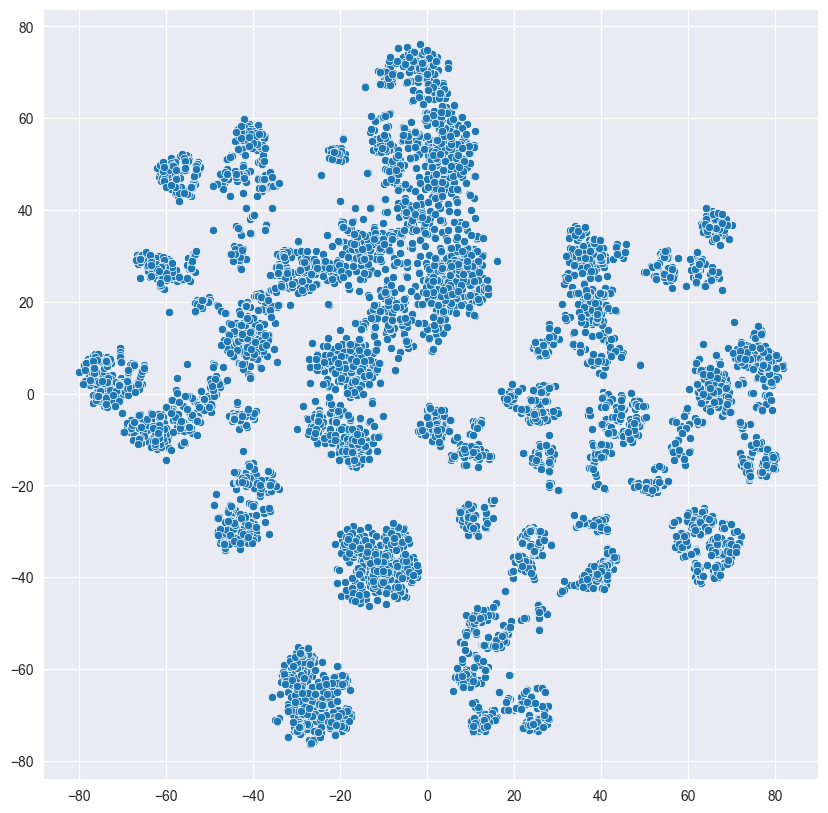

In [231]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)
tsne_transformed = tsne.fit_transform(X.values)
plt.figure(figsize=(10, 10))
sns.scatterplot(
    x=tsne_transformed[:, 0],
    y=tsne_transformed[:, 1],
    palette="CMRmap",
    legend='full'
);

In [488]:
#есть какие-то кластеры

# Подход 1. Косинусное расстояние

In [232]:
item_similarities = cosine_similarity(X, X)

In [233]:
item_similarities

array([[1.        , 0.57170855, 0.93713444, ..., 0.4317755 , 0.58752785,
        0.95132259],
       [0.57170855, 1.        , 0.57204272, ..., 0.60873484, 0.26324043,
        0.5805734 ],
       [0.93713444, 0.57204272, 1.        , ..., 0.42115462, 0.59880293,
        0.93678681],
       ...,
       [0.4317755 , 0.60873484, 0.42115462, ..., 1.        , 0.18640258,
        0.44401537],
       [0.58752785, 0.26324043, 0.59880293, ..., 0.18640258, 1.        ,
        0.60232383],
       [0.95132259, 0.5805734 , 0.93678681, ..., 0.44401537, 0.60232383,
        1.        ]])

In [234]:
def get_recommendations(item_id, similarities):
    scores=list(enumerate(similarities[item_id]))
    scores=sorted(scores, key= lambda x: x[1], reverse=True)
    scores=scores[1:11] #get 10 most similar, except itself
    rest_indices=[i[0] for i in scores]
    scores=[i[1] for i in scores]
    return rest_indices, scores

def print_recommendation(item_id, indices, distances):

    print("for {}".format(data_info.iloc[item_id]['name']))
    print("characterictics: ")
    print("rest_type:")
    print(data_info.iloc[item_id]['rest_type'])
    print("cuisines:")
    print(data_info.iloc[item_id]['cuisines'])
    print("located:")
    print(data_info.iloc[item_id]['city'])
    print("with rate:")
    print(data_info.iloc[item_id]['rate'])
    print("\n\n")
    print("---------------------------")
    print("recommend:\n")
    results=pd.DataFrame(data_info.iloc[indices][['name','rest_type','cuisines','rate','city']])
    results['distances']=distances
    return results



In [235]:
indices, distances=get_recommendations(name_to_ind['Starbucks'], item_similarities)
print_recommendation(name_to_ind['Starbucks'], indices, distances)

for Starbucks
characterictics: 
rest_type:
['cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'food court', 'cafe', 'food court', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe']
cuisines:
['cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe

,name,rest_type,cuisines,rate,city,distances
1651,Cuppa,"[cafe, cafe, cafe, cafe, casual dining, cafe, ...","[cafe, fast food, cafe, fast food, cafe, fast ...",3.342105,"[banashankari, bannerghatta road, bannerghatta...",0.545801
37,36th Cross Coffee Mane,"[quick bites, quick bites, quick bites, quick ...","[south indian, chinese, beverages, cafe, coffe...",3.650000,"[basavanagudi, basavanagudi, jayanagar, jayana...",0.508424
3525,La Grande Cafe,"[cafe, cafe, cafe, cafe, cafe, cafe]","[cafe, cafe, cafe, cafe, cafe, cafe]",3.800000,"[basavanagudi, basavanagudi, jayanagar, jayana...",0.507629
238,Alchemy Coffee Roasters,"[cafe, cafe, cafe, cafe, cafe, cafe]","[cafe, cafe, cafe, cafe, cafe, cafe]",4.200000,"[basavanagudi, basavanagudi, jayanagar, jayana...",0.506238
1141,Cafe Talk,"[cafe, casual dining, cafe, casual dining, caf...","[cafe, continental, north indian, bakery, dess...",3.300000,"[bannerghatta road, bannerghatta road, btm, bt...",0.497631
645,Barista,"[cafe, cafe, cafe, cafe, cafe, cafe, cafe, caf...","[cafe, cafe, cafe, cafe, cafe, cafe, cafe, caf...",3.590000,"[brigade road, brigade road, btm, church stree...",0.496537
2607,Hearts Unlock Cafe,"[cafe, cafe, cafe, cafe, cafe, cafe, cafe, caf...","[cafe, healthy food, cafe, healthy food, cafe,...",3.191667,"[bannerghatta road, bannerghatta road, bannerg...",0.495141
5484,Shanghai Times,"[food court, quick bites, quick bites, food co...","[chinese, asian, chinese, chinese, chinese, as...",3.206250,"[bannerghatta road, brookefield, brookefield, ...",0.495024
1724,Davanagere Benne Dosa,"[quick bites, quick bites, quick bites, quick ...","[south indian, south indian, south indian, sou...",3.042857,"[basavanagudi, basavanagudi, jayanagar, jayana...",0.492038
1599,Crave Bit Cafe,"[cafe, cafe, cafe, cafe, cafe, cafe, cafe, caf...","[cafe, cafe, cafe, cafe, cafe, cafe, cafe, caf...",4.855556,"[bannerghatta road, bannerghatta road, bannerg...",0.489322


# Подход 2. Nearest Neighbours algorithm

In [236]:
from scipy.sparse import csr_matrix
X_sparse=csr_matrix(X)

In [237]:
X_sparse

<7227x2949 sparse matrix of type '<class 'numpy.float64'>'
	with 128120 stored elements in Compressed Sparse Row format>

In [238]:
from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=30, n_jobs=-1)

In [239]:
def get_knn_recommendations(item_id, sparse_matrix, model):

    model.fit(sparse_matrix)

    distances, indices = model.kneighbors(sparse_matrix[item_id], n_neighbors=11)
    distances=distances.flatten()[1:11] #исключаем сам ресторан из списка
    indices=indices.flatten()[1:11]

    return indices, distances




In [240]:
#предсказываем для ресторана Starbucks
indices, distances=get_knn_recommendations(name_to_ind['Starbucks'], X_sparse, model_knn)
print_recommendation(name_to_ind['Starbucks'], indices, distances)

for Starbucks
characterictics: 
rest_type:
['cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'food court', 'cafe', 'food court', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe']
cuisines:
['cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe

,name,rest_type,cuisines,rate,city,distances
1651,Cuppa,"[cafe, cafe, cafe, cafe, casual dining, cafe, ...","[cafe, fast food, cafe, fast food, cafe, fast ...",3.342105,"[banashankari, bannerghatta road, bannerghatta...",0.454199
37,36th Cross Coffee Mane,"[quick bites, quick bites, quick bites, quick ...","[south indian, chinese, beverages, cafe, coffe...",3.650000,"[basavanagudi, basavanagudi, jayanagar, jayana...",0.491576
3525,La Grande Cafe,"[cafe, cafe, cafe, cafe, cafe, cafe]","[cafe, cafe, cafe, cafe, cafe, cafe]",3.800000,"[basavanagudi, basavanagudi, jayanagar, jayana...",0.492371
238,Alchemy Coffee Roasters,"[cafe, cafe, cafe, cafe, cafe, cafe]","[cafe, cafe, cafe, cafe, cafe, cafe]",4.200000,"[basavanagudi, basavanagudi, jayanagar, jayana...",0.493762
1141,Cafe Talk,"[cafe, casual dining, cafe, casual dining, caf...","[cafe, continental, north indian, bakery, dess...",3.300000,"[bannerghatta road, bannerghatta road, btm, bt...",0.502369
645,Barista,"[cafe, cafe, cafe, cafe, cafe, cafe, cafe, caf...","[cafe, cafe, cafe, cafe, cafe, cafe, cafe, caf...",3.590000,"[brigade road, brigade road, btm, church stree...",0.503463
2607,Hearts Unlock Cafe,"[cafe, cafe, cafe, cafe, cafe, cafe, cafe, caf...","[cafe, healthy food, cafe, healthy food, cafe,...",3.191667,"[bannerghatta road, bannerghatta road, bannerg...",0.504859
5484,Shanghai Times,"[food court, quick bites, quick bites, food co...","[chinese, asian, chinese, chinese, chinese, as...",3.206250,"[bannerghatta road, brookefield, brookefield, ...",0.504976
1724,Davanagere Benne Dosa,"[quick bites, quick bites, quick bites, quick ...","[south indian, south indian, south indian, sou...",3.042857,"[basavanagudi, basavanagudi, jayanagar, jayana...",0.507962
1599,Crave Bit Cafe,"[cafe, cafe, cafe, cafe, cafe, cafe, cafe, caf...","[cafe, cafe, cafe, cafe, cafe, cafe, cafe, caf...",4.855556,"[bannerghatta road, bannerghatta road, bannerg...",0.510678


# Пробуем понижение размерности

In [241]:
# Строим матрицу ковариации
cov_mat=np.cov(X.T)

In [242]:
cov_mat

array([[ 0.01086164,  0.00106384,  0.002037  , ...,  0.00041361,
        -0.00904805,  0.00904805],
       [ 0.00106384,  0.0013285 ,  0.00098909, ...,  0.0004316 ,
        -0.00430687,  0.00430687],
       [ 0.002037  ,  0.00098909,  0.0059015 , ..., -0.00486973,
        -0.01438739,  0.01438739],
       ...,
       [ 0.00041361,  0.0004316 , -0.00486973, ...,  0.24762815,
         0.00517268, -0.00517268],
       [-0.00904805, -0.00430687, -0.01438739, ...,  0.00517268,
         0.09433383, -0.09433383],
       [ 0.00904805,  0.00430687,  0.01438739, ..., -0.00517268,
        -0.09433383,  0.09433383]])

In [243]:
# По полученной матрице ковариации находим собственные вектора и собственные значения
eigen_values, eigen_vectors=np.linalg.eig(cov_mat)
print("собственные значения ->", eigen_values)

собственные значения -> [0.50245655+0.j 0.20096122+0.j 0.09287518+0.j ... 0.        +0.j
 0.        +0.j 0.        +0.j]


In [244]:
# Считаем общую сумму собственных значений
eig_sum=np.sum(np.real(eigen_values))
eig_sum

1.963914407608765

In [245]:
# Считаем коэффициент объясняемой дисперсии для каждого собственного значения
# (подсказка (текущая дисперсия / общую сумму собственных значений) для каждого собственного вектора)
var_explaned=[(i/eig_sum) for i in sorted(np.real(eigen_values), reverse=True)]

In [246]:
# Считаем кумулятивную сумму объясняемой дисперсии (подсказка: np.cumsum())
cum_var_explaned=np.cumsum(var_explaned)

In [247]:
cum_var_explaned

array([0.25584442, 0.3581713 , 0.40546214, ..., 1.        , 1.        ,
       1.        ])

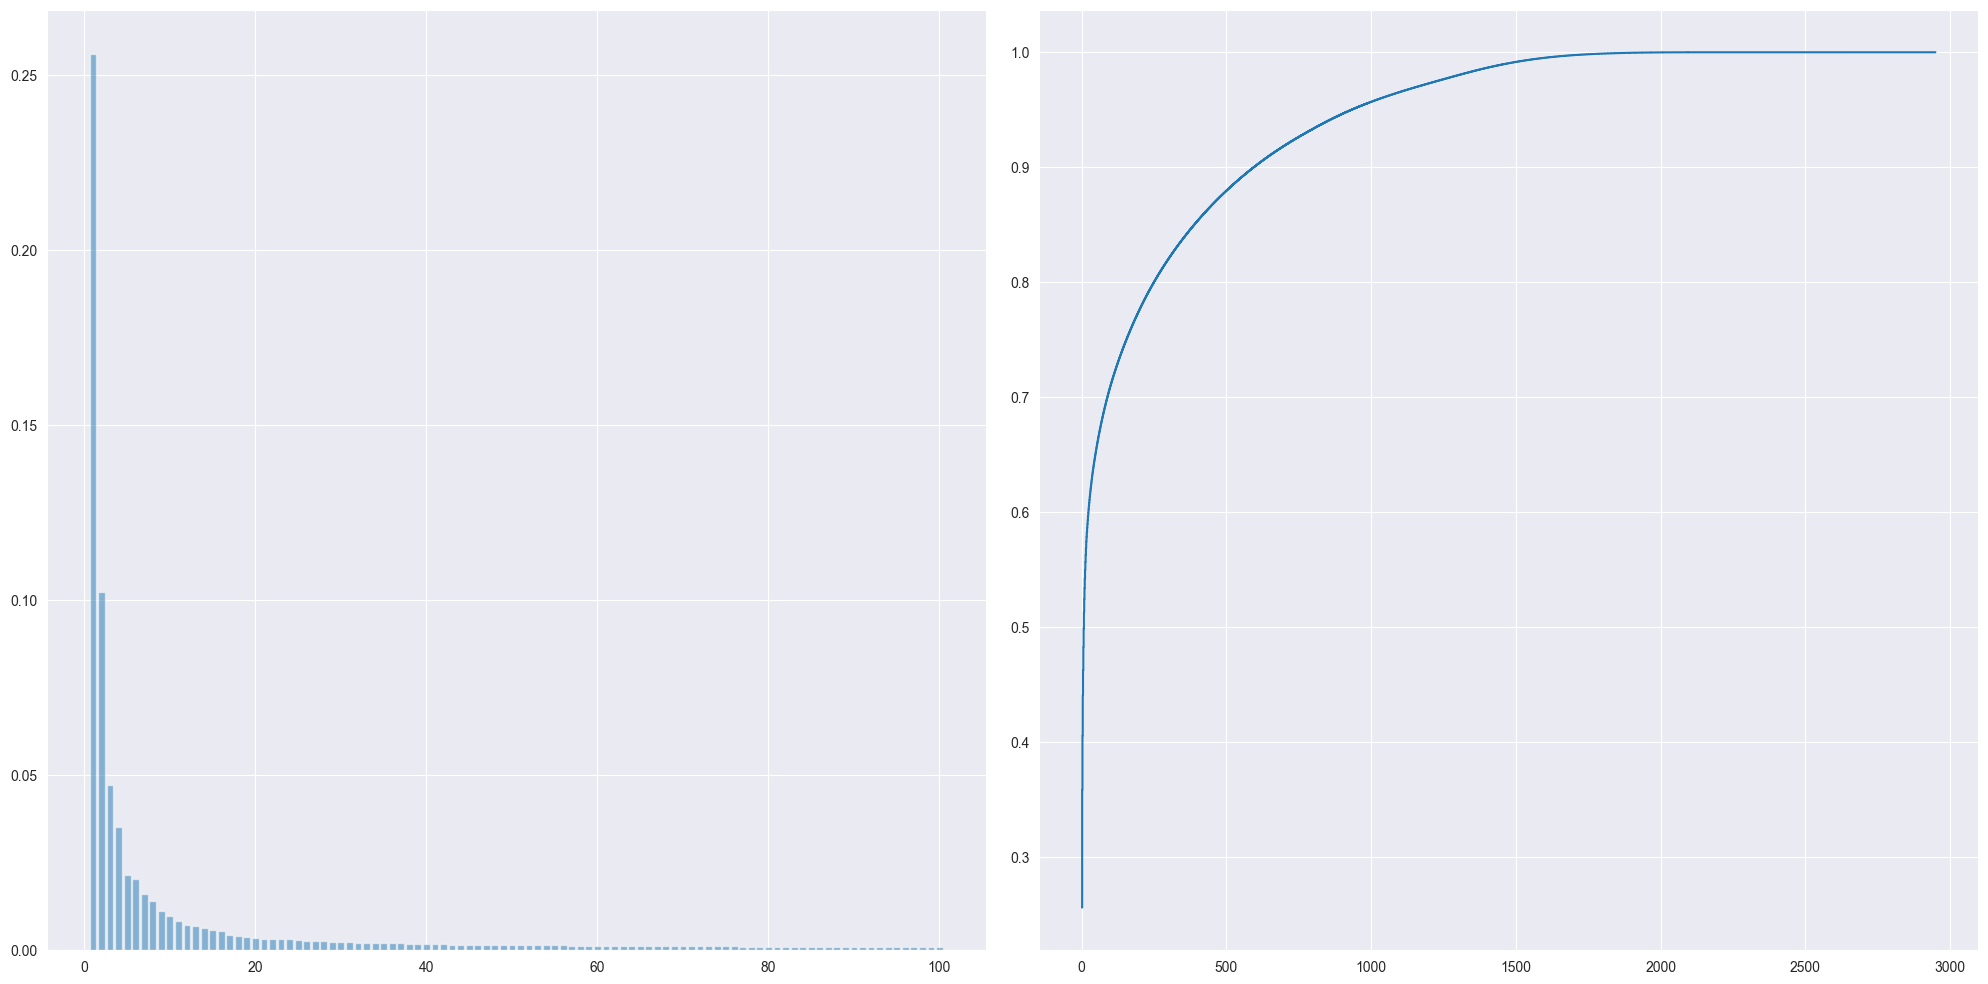

In [248]:
fig, axs=plt.subplots(nrows=1, ncols=2, figsize=(20,10))
fig.tight_layout()

#первые 100 признаков
axs[0].bar(range(1,101), var_explaned[:100], alpha=0.5, align='center', label='Индивидуальная объясненная дисперсия')


axs[1].step(range(1,2950), cum_var_explaned, where='mid', label='Кумулятивная объясненная дисперсия')
# plt.ylabel('Коэффициент объясненной дисперсии')
# plt.xlabel('Индекс главного компонента')
# plt.legend(loc='best')
plt.show()

In [249]:
S_thr = 0.85  # задаем порог для накопленной суммы собственных значений

# определяем необходимое число компонент для заданного порога
n_comp = np.argmax(np.where(cum_var_explaned > S_thr, 1, 0))

print('n_comp=%d S=%.3f' % (n_comp, cum_var_explaned[n_comp]))

n_comp=388 S=0.850


In [250]:
# попробуем снизить размерность до 400
from sklearn.decomposition import PCA



pca = PCA(n_components=400, random_state=42)

X_pca = pca.fit_transform(X)

In [251]:
X_pca

array([[-7.88151978e-01, -2.04448086e-01, -1.02275193e-01, ...,
         9.03025129e-04,  1.61751748e-03,  4.83810324e-05],
       [ 6.71323509e-01, -1.03698609e-01,  2.89576450e-01, ...,
        -1.61391376e-04,  1.62108979e-03, -1.93045374e-03],
       [-7.95856302e-01, -1.65735870e-01, -9.80589242e-02, ...,
        -3.60542109e-03, -1.63124912e-03, -1.40942039e-03],
       ...,
       [ 6.36781726e-01, -1.32825676e-01, -1.66240309e-01, ...,
         5.77067022e-03,  1.45676096e-02, -4.04128233e-02],
       [-8.26717772e-01,  1.22319983e+00, -1.92487511e-01, ...,
         6.84040847e-03, -5.75448087e-03,  2.31860665e-03],
       [-7.89332538e-01, -1.80975971e-01, -9.66542182e-02, ...,
        -7.72841038e-04, -5.33983088e-04, -3.92499239e-04]])

In [252]:
#теперь применим к этому датасету алгоритм NearestNeighbours

In [253]:
X_sparse_pca=csr_matrix(X_pca)

In [254]:
#предсказываем для ресторана Starbucks
indices, distances=get_knn_recommendations(name_to_ind['Starbucks'], X_sparse_pca, model_knn)
print_recommendation(name_to_ind['Starbucks'], indices, distances)

for Starbucks
characterictics: 
rest_type:
['cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'food court', 'cafe', 'food court', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe', 'cafe']
cuisines:
['cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe', 'desserts', 'cafe

,name,rest_type,cuisines,rate,city,distances
6610,The Roastery,"[cafe, cafe]","[cafe, cafe]",4.300000,"[kalyan nagar, kammanahalli]",0.538421
1651,Cuppa,"[cafe, cafe, cafe, cafe, casual dining, cafe, ...","[cafe, fast food, cafe, fast food, cafe, fast ...",3.342105,"[banashankari, bannerghatta road, bannerghatta...",0.591078
1077,Cafe Coffee Day,"[cafe, cafe, cafe, cafe, cafe, cafe, cafe, caf...","[cafe, fast food, cafe, fast food, cafe, fast ...",3.237079,"[banashankari, banashankari, banashankari, ban...",0.612524
3525,La Grande Cafe,"[cafe, cafe, cafe, cafe, cafe, cafe]","[cafe, cafe, cafe, cafe, cafe, cafe]",3.800000,"[basavanagudi, basavanagudi, jayanagar, jayana...",0.638196
238,Alchemy Coffee Roasters,"[cafe, cafe, cafe, cafe, cafe, cafe]","[cafe, cafe, cafe, cafe, cafe, cafe]",4.200000,"[basavanagudi, basavanagudi, jayanagar, jayana...",0.667456
37,36th Cross Coffee Mane,"[quick bites, quick bites, quick bites, quick ...","[south indian, chinese, beverages, cafe, coffe...",3.650000,"[basavanagudi, basavanagudi, jayanagar, jayana...",0.669617
645,Barista,"[cafe, cafe, cafe, cafe, cafe, cafe, cafe, caf...","[cafe, cafe, cafe, cafe, cafe, cafe, cafe, caf...",3.590000,"[brigade road, brigade road, btm, church stree...",0.669618
6101,TAB - Take A Break,"[cafe, cafe, cafe, cafe, cafe, cafe, cafe, caf...","[cafe, continental, italian, cafe, continental...",4.100000,"[bannerghatta road, bannerghatta road, bannerg...",0.672021
1687,Daily Bread,"[bakery, quick bites, bakery, quick bites, bak...","[bakery, fast food, italian, bakery, fast food...",2.969697,"[bannerghatta road, bannerghatta road, brookef...",0.677475
2607,Hearts Unlock Cafe,"[cafe, cafe, cafe, cafe, cafe, cafe, cafe, caf...","[cafe, healthy food, cafe, healthy food, cafe,...",3.191667,"[bannerghatta road, bannerghatta road, bannerg...",0.679017


# Оценка рекомендаций

Построим разбиение на классы с помощью алгоритма KMeans и сравним те классы, которые получаются с нашей рекомендацией, с актуальным классом, который будет присвоен искомому ресторану с помощью алгоритма KMeans

In [255]:
#для алгоритма произведем нормировку данных
from sklearn.preprocessing import normalize
X_Norm = normalize(X_pca)

[2183.2069804648354, 1969.9504364554334, 1839.0223157074643, 1751.2180417150723, 1682.400256460734, 1646.506515234775, 1594.679750115078, 1569.8140970285908]


Text(0.5, 1.0, 'The Elbow Method showing the optimal k')

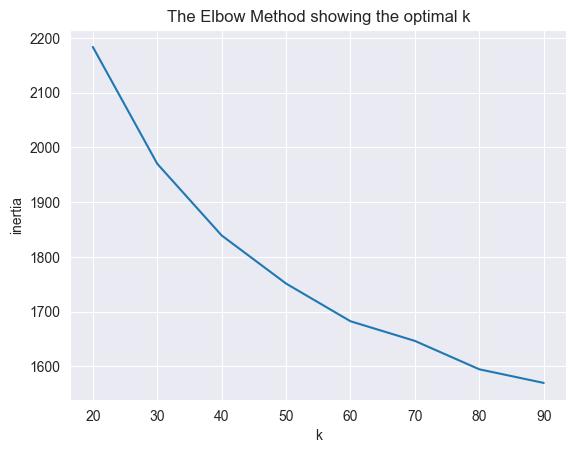

In [256]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
inertia = []
k = range(20, 100, 10)
for k_i in k:
    km = KMeans(n_clusters=k_i).fit(X_Norm)
    inertia.append(km.inertia_)


print(inertia)

plt.plot(k, inertia)
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('The Elbow Method showing the optimal k')

In [257]:
n_clasters=30
km=KMeans(n_clusters=n_clasters)
km.fit(X_Norm)
labels = km.labels_

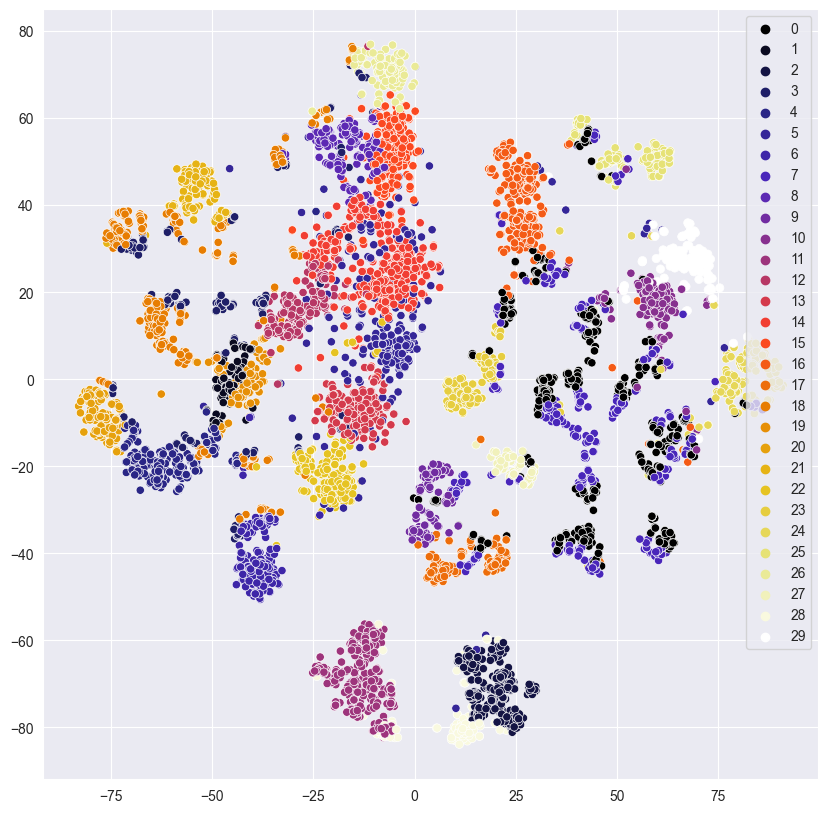

In [258]:
tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)
tsne_transformed = tsne.fit_transform(X_Norm)
plt.figure(figsize=(10, 10))
sns.scatterplot(
    x=tsne_transformed[:, 0],
    y=tsne_transformed[:, 1],
    hue=labels.astype(int),
    palette="CMRmap",
    legend='full'
);

In [259]:
#функция для подсчета точности
def accuracy(item_id, labels, indices, show=False):
    true_class=labels[item_id]
    predicted_classes=labels[indices]
    if show:
        print("The true class is: {}".format(true_class))
        print("predicted classes:")
        print(predicted_classes)
    accur=len(predicted_classes[predicted_classes==true_class])/len(predicted_classes)
    return accur


In [286]:
#например для третьей модели
indices, distances=get_knn_recommendations(10, X_sparse_pca, model_knn)
print(accuracy(10, labels, indices, True))

The true class is: 15
predicted classes:
[15 15 15 15 15 15 15 15  8 15]
0.9


In [287]:
#например для второй модели
indices, distances=get_knn_recommendations(10, X_sparse, model_knn)
print(accuracy(10, labels, indices, True))

The true class is: 15
predicted classes:
[15 15 15 15  8 15  8 15 15 15]
0.8


In [288]:
#например для первой модели
indices, distances=get_recommendations(10, item_similarities)
print(accuracy(10, labels, indices, True))

The true class is: 15
predicted classes:
[15 15 15 15  8 15  8 15 15 15]
0.8


In [264]:
#выберем для теста 20% индексов случайных и проверим точность
test=np.random.choice(X.index.values, int(0.2*X.shape[0]))

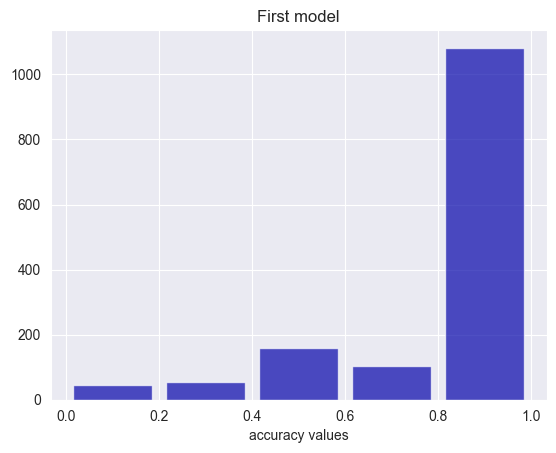

In [266]:
#для первой модели
accuracies=np.zeros(len(test))
for i, ind in enumerate(test):
    indices, distances=get_recommendations(ind, item_similarities)
    accuracies[i]=accuracy(ind, labels, indices)
plt.title("First model")
plt.hist(x=accuracies, bins=5, color='#0504aa',
                            alpha=0.7, rwidth=0.85);
plt.xlabel("accuracy values")
plt.show();

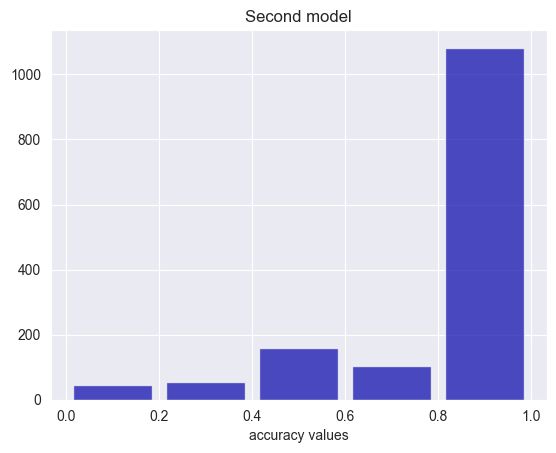

In [267]:
#для второй модели
accuracies=np.zeros(len(test))
for i, ind in enumerate(test):
    indices, distances=get_knn_recommendations(ind, X_sparse, model_knn)
    accuracies[i]=accuracy(ind, labels, indices)
plt.title("Second model")
plt.hist(x=accuracies, bins=5, color='#0504aa',
                            alpha=0.7, rwidth=0.85);
plt.xlabel("accuracy values")
plt.show();

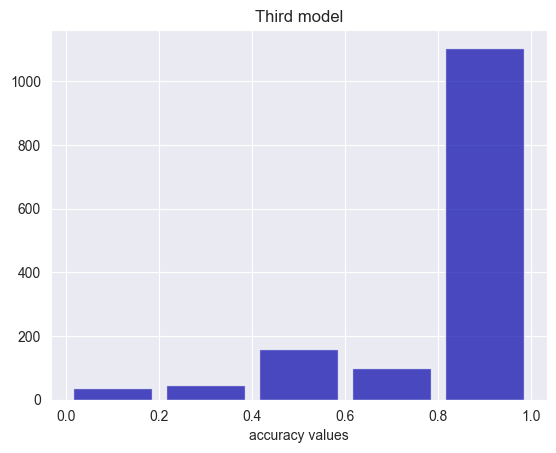

In [268]:
#для третьей модели
accuracies=np.zeros(len(test))
for i, ind in enumerate(test):
    indices, distances=get_knn_recommendations(ind, X_sparse_pca, model_knn)
    accuracies[i]=accuracy(ind, labels, indices)
plt.title("Third model")
plt.hist(x=accuracies, bins=5, color='#0504aa',
                            alpha=0.7, rwidth=0.85);
plt.xlabel("accuracy values")
plt.show();

Все результаты примерно одинаковые